In [4]:
# Uncomment the string below to install all needed packages
#!pip install numpy matplotlib seaborn scikit-learn pandas scipy SaLib 

Hoβ do parametres influence X

In [45]:
# crete dataframe for simulations

import numpy as np
import math
import pandas as pd

# quantity of random combinations
num_samples = 100_000

# Parameters' ranges
μ_range = (0.01, 0.5) # age-independent mortality
C_range = (30, 500) # pollen required to make one forager
S0_range = (150, 300) # production of the first ant
m_range = (0.001, 10.0) # 1 / m = max production of all ants at any n
L_range = (0.05, 1.0) # the proportion of molecules to be damaged to kill the organism
D_range = (0.01, 0.9) # damage per day
F_range = (0.05, 100) # daily forager consumption

results = []

for _ in range(num_samples):
    μ = np.random.uniform(*μ_range)
    C = np.random.uniform(*C_range)
    S0 = np.random.uniform(*S0_range)
    m = np.random.uniform(*m_range)
    L = np.random.uniform(*L_range)
    D = np.random.uniform(*D_range)
    F = np.random.uniform(*F_range)

    # M must be less or equal than D
    M = np.random.uniform(0.001, D - 1e-6)

    try:
        X = (C * L) / (D - M)
        p = μ * X
        λ = (M + F) / S0
        β = (μ * C) / S0
        η = λ + β / (1 - np.exp(-p))

        if η <= 0:
            continue

        N = (-1 / (m * S0)) * math.log(λ + β / (1 - np.exp(-p)))
        W = (1 / m) * (1 - η + η * math.log(η)) 
        
        
        # Count n0 for those βho surivived to X 
        n0 = (μ * N) / (1 - np.exp(-p))
        nX = (n0 * np.exp(-μ * X)) / N # n(t = X)
        
        # Count S
        S =  S0 * np.exp(-m * S0 * N)

        results.append({
            "μ": μ,
            "C": C,
            "S0": S0,
            "m": m,
            "L": L,
            "D": D,
            "M": M,
            "F": F,
            "X": X,
            'n0':n0,
            "N": N,
            "nX": nX,
            "S": S,
            "W": W
        })

    except (ZeroDivisionError, OverflowError, ValueError, FloatingPointError):
        continue

# Преобразуем результаты в DataFrame
df_results = pd.DataFrame(results)


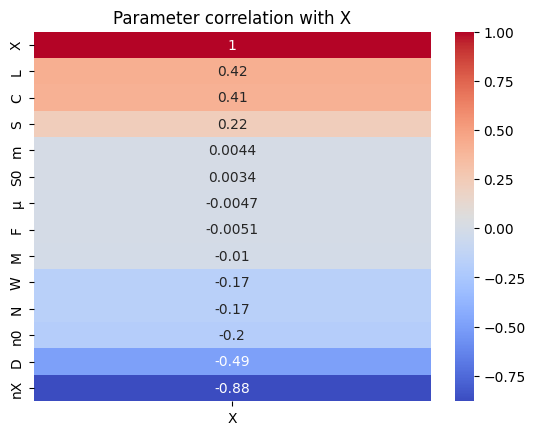

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_results.corr(method='spearman')  # или method='pearson'
sns.heatmap(correlation_matrix[['X']].sort_values(by='X', ascending=False), annot=True, cmap='coolwarm')
plt.title('Parameter correlation with X')
plt.savefig("first_model_parameter_correlation.pdf", format='pdf', bbox_inches='tight')
plt.show()

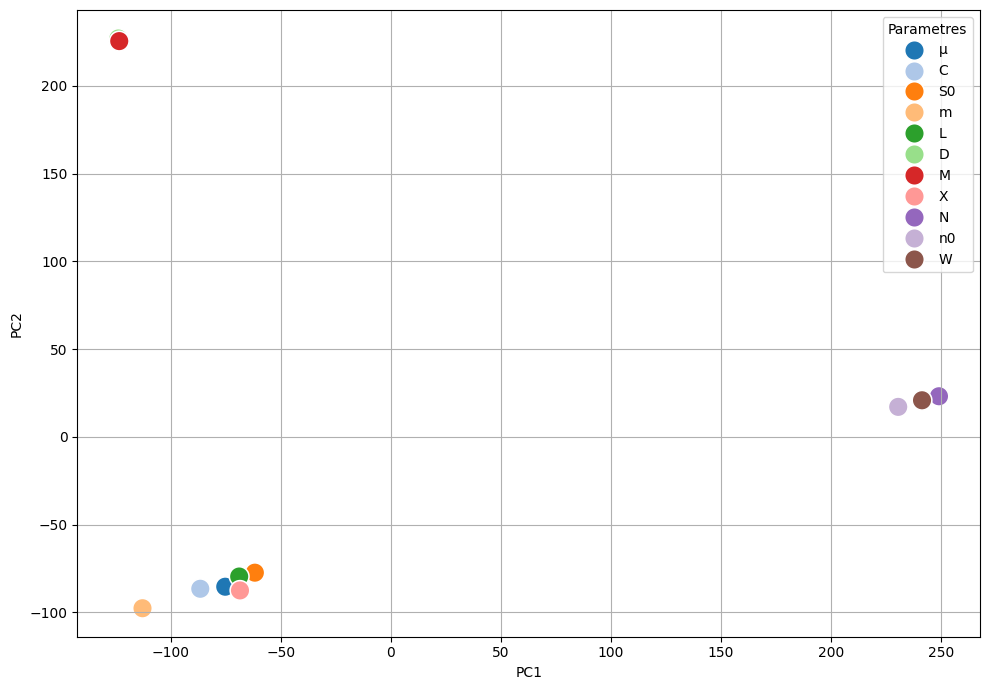

In [7]:
# PCA analysis
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Define needed parameters from the dataset
params = ["μ", "C", "S0", "m", "L", "D", "M", "X", "N", "n0", "W"]
data = df_results[params]

# Масштабируем данные по строкам (наблюдениям)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Транспонируем — теперь строки это параметры
transposed = pd.DataFrame(scaled_data, columns=params).T

# Снова применяем PCA, но теперь на параметрах
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(transposed)

# Строим график
pca_param_df = pd.DataFrame(pca_coords, columns=["PC1", "PC2"])
pca_param_df["param"] = params

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_param_df, x="PC1", y="PC2", hue="param", palette="tab20", s=200)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Parametres")
plt.savefig("first_model_parameter_pca.pdf", format='pdf', bbox_inches='tight')
plt.show()


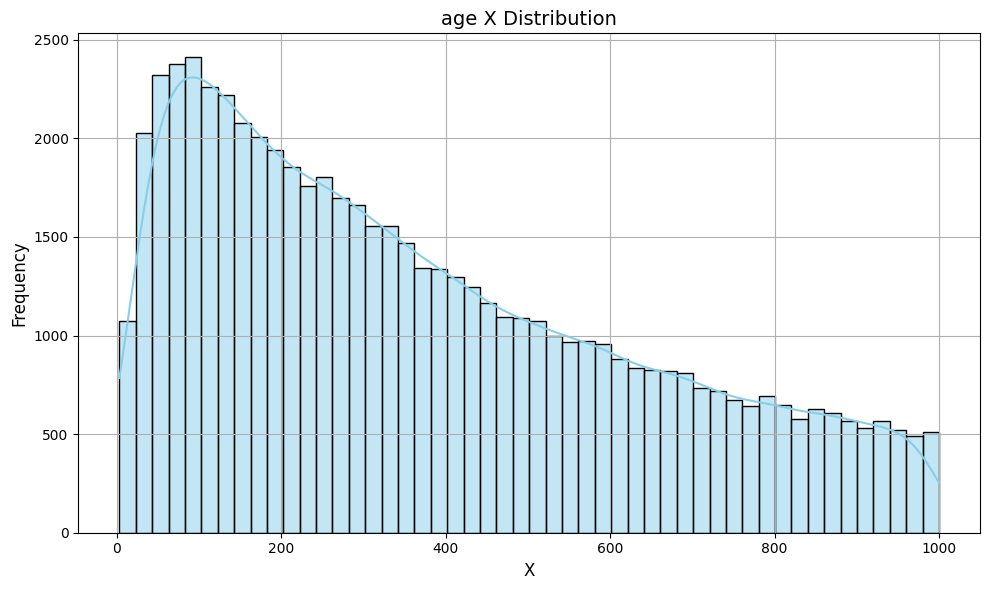

In [8]:
# Age distribution

import matplotlib.pyplot as plt
import seaborn as sns

# Exclude X values higher than 1000 to see the needed distribution clearer
filtered_X = df_results[df_results["X"] < 1000]['X']

plt.figure(figsize=(10, 6))
sns.histplot(filtered_X, bins=50, kde=True, color='skyblue')
plt.title("age X Distribution", fontsize=14)
plt.xlabel("X", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("first_model_age_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()

Global sensitivity analysis

/var/folders/9q/pv4ly36x3xg6y47msgdwbk640000gn/T/ipykernel_75714/3512589495.py:32: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N=1600, calc_second_order=False)
/Users/samiraisin/virtualenvs/.venv/lib/python3.12/site-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1600) is equal to `2^n`.
        
  warnings.warn(msg)
/Users/samiraisin/virtualenvs/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


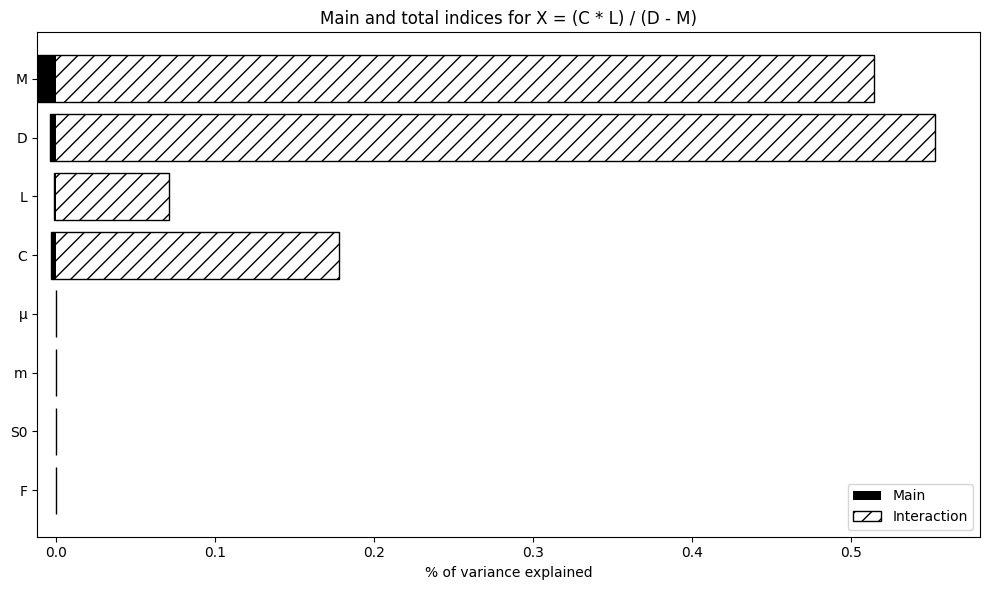

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol

# 1. Define the model
def model(params):
    F, S0, m, μ, C, L, D, M, = params
    denominator = D - M
    if abs(denominator) < 1e-6:  # Avoid division by zero
        return np.nan
    return (C * L) / denominator

# 2. Define the problem (parameter names and bounds)
problem = {
    'num_vars': 8,
    'names': [ 'F', 'S0', 'm', 'μ', 'C', 'L', 'D', 'M'],
    'bounds': [
        
        [0.01, 2.0], # F
        [50.0, 200.0], # S0
        [1e-6, 10.0], # m
        [0.05, 0.15], # μ
        [1.0, 300.0],   # C
        [0.01, 1.0],   # L
        [0.001,0.9],  # D
        [0.001,0.9],     # M — ensure D > M
    ]
}

# 3. Generate samples using Saltelli's method
param_values = saltelli.sample(problem, N=1600, calc_second_order=False)

# 4. Evaluate the model
Y = np.array([model(x) for x in param_values])
mask = ~np.isnan(Y)
Y = Y[mask]
param_values = param_values[mask]


# 5. Run Sobol sensitivity analysis
Si = sobol.analyze(problem, Y, calc_second_order=False)


# 6. Prepare data for plotting
main_effects = Si['S1']
total_effects = Si['ST']
interaction_effects = total_effects - main_effects
params = problem['names']

# 7. Plot like panel A
fig, ax = plt.subplots(figsize=(10, 6))
bars_main = ax.barh(params, main_effects, color='black', label='Main')
bars_int = ax.barh(params, interaction_effects, left=main_effects, hatch='//', edgecolor='black', fill=False, label='Interaction')

ax.set_xlabel('% of variance explained')
ax.set_title('Main and total indices for X = (C * L) / (D - M)')
ax.legend()
plt.tight_layout()
plt.savefig("first_model_parameter_interaction_variance.pdf", format='pdf', bbox_inches='tight')
plt.show()

Counting Functions and Constants

In [10]:
# Function to define the best S0 parameter for some sections where it would be a constant
def compute_S0(U, N, m):
    term = 1 - m * U
    if term <= 0:
        raise ValueError("ln(1 - m * U) is undefined or negative. Adjust U or m.")
    S0 = -np.log(term) / (m * N)
    return S0

# These parameteres are real
U = 900000
N = 10000
m = 1e-6

S0 = compute_S0(U, N, m)
print(f"S0 ≈ {S0:.3f}")

S0 ≈ 230.259


In [11]:
import numpy as np
from scipy.optimize import root_scalar

# -----------------------
# Constants (example)
# -----------------------
X_range = np.logspace(1, 100, 100)
μ = 0.134
m = 1e-6
# v can be set globally or passed explicitly
v = 0.001

M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta = (μ * C) / S0

# -----------------------
# Numerical safety helpers
# -----------------------
_eps = 1e-12
_exp_clip = 700.0  # to avoid overflow in exp

def safe_div(a, b):
    """Safe division: avoid division by zero by using a small epsilon."""
    if np.isscalar(b):
        if abs(b) < _eps:
            return a / (_eps * np.sign(b) if b != 0 else _eps)
    else:
        b = np.where(np.abs(b) < _eps, np.sign(b) * _eps + _eps, b)
    return a / b

def safe_log(x):
    """Safe log: return np.nan if x <= 0 (physically invalid), otherwise log(x)."""
    x = np.asarray(x)
    out = np.full_like(x, np.nan, dtype=float)
    mask = x > _eps
    if np.any(mask):
        out[mask] = np.log(x[mask])
    if out.shape == ():
        return float(out)
    return out

def safe_exp(x):
    """Safe exponent with clipping to avoid overflow."""
    x = np.asarray(x, dtype=float)
    x = np.clip(x, -_exp_clip, _exp_clip)
    return np.exp(x)

# -----------------------
# Core functions
# -----------------------
def solve_p(L, bracket=(1e-6, 10)):
    """
    Solve for p given L using Brent's method.
    If root_scalar fails it will raise — wrap calls in try/except where used.
    """
    sqrt_L = np.sqrt(L)
    def f(p):
        # f(p) = sqrt(L) * (1 - e^-p) - p * e^{-p/2}
        return sqrt_L * (1 - safe_exp(-p)) - p * safe_exp(-p/2)
    sol = root_scalar(f, bracket=bracket, method='brentq')
    return sol.root

def p_from_X(X):
    """Convert X to p by p = μ * X"""
    return X * μ

def n0(p):
    """
    Compute n0(p). Return np.nan when inner expressions are invalid.
    n0 = -μ / ((1-exp(-p)) * m * S0) * log(alpha + beta/(1-exp(-p)))
    """
    e_minus_p = safe_exp(-p)
    denom = (1 - e_minus_p)
    if np.any(denom <= _eps):
        # if denom is zero (p extremely small), the expression is singular
        # return np.nan for those p
        # You can consider series expansion for small p if needed
        return np.nan
    inner = alpha + beta / denom
    if np.any(inner <= _eps):
        return np.nan
    ln_inner = safe_log(inner)
    # denominator full:
    full_denom = denom * m * S0
    return -μ * ln_inner / full_denom

def N_from_n0(n0_val, p, I):
    """Compute N from n0 using the global v (legacy signature)."""
    # guard: if n0_val is nan, propagate
    if np.isnan(n0_val):
        return np.nan
    one_plus_vI = (1 + v * I)
    # clip to avoid negative or zero
    if one_plus_vI <= 0:
        return np.nan
    return n0_val * (1 - safe_exp(-p * one_plus_vI)) / (μ * one_plus_vI)

def phi(p, I):
    """phi with global v"""
    n0_val = n0(p)
    if np.isnan(n0_val):
        return np.nan
    e_p = safe_exp(-p)
    e_p_vI = safe_exp(-p * (1 + v * I))
    numerator = (v * I) - (1 + v * I) * e_p + e_p_vI
    denom = (1 + v * I)
    if denom == 0:
        return np.nan
    return (n0_val / μ) * safe_div(numerator, denom)

def solve_I(p, max_iter=1000, tol=1e-8, omega=0.7):
    """
    Fixed-point iteration with relaxation to find I: I_{k+1} = omega*phi + (1-omega)*I_k.
    If it does not converge, try fallback secant/root_scalar attempts.
    Returns root or np.nan.
    """
    n0_val = n0(p)
    if np.isnan(n0_val):
        return np.nan

    I = 1.0
    for _ in range(max_iter):
        newI = phi(p, I)
        if np.isnan(newI) or np.isinf(newI):
            return np.nan
        newI_relaxed = omega * newI + (1 - omega) * I
        # enforce non-negative
        newI_relaxed = max(newI_relaxed, 0.0)
        if abs(newI_relaxed - I) < tol:
            return newI_relaxed
        I = newI_relaxed

    # fallback: attempt to find root of f(I) = phi(p,I) - I using root_scalar (secant)
    def f(I_):
        val = phi(p, I_)
        if np.isnan(val):
            return np.nan
        return val - I_
    try:
        # try secant with two initial guesses if they give finite values
        a, b = 0.0, max(1.0, 10.0)
        fa = f(a); fb = f(b)
        if np.isfinite(fa) and np.isfinite(fb) and fa * fb < 0:
            sol = root_scalar(f, bracket=[a, b], method='brentq')
            return sol.root
        else:
            # try secant method
            sol = root_scalar(f, x0=0.0, x1=1.0, method='secant', maxiter=200)
            return sol.root if sol.converged else np.nan
    except Exception:
        return np.nan

def W_from_N(N_val, p, I):
    """
    Compute W = (1 - exp(-m*S0*N))/m - (N+I)*(M+F) - (N+I)*((μ*C)/(1-exp(-p)))
    Be careful with denominator 1-exp(-p).
    """
    if np.isnan(N_val):
        return np.nan
    term1 = safe_div(1 - safe_exp(-m * S0 * N_val), m)
    term2 = (N_val + I) * (M + F)
    denom = (1 - safe_exp(-p))
    if denom <= _eps:
        return np.nan
    term3 = (N_val + I) * ((μ * C) / denom)
    return term1 - term2 - term3

def W_from_Xn0(N_val, p, I, n0_val):
    """
    Compute W = (1 - exp(-m*S0*N))/m - (N+I)*(M+F) - n0*C
    """
    if np.isnan(N_val) or np.isnan(n0_val):
        return np.nan
    term1 = safe_div(1 - safe_exp(-m * S0 * N_val), m)
    term2 = (N_val + I) * (M + F)
    term3 = n0_val * C
    return term1 - term2 - term3

# ---------- versions that take v explicitly ----------
def N_from_n0_v(n0_val, p, I, v_local):
    """N calculation with explicit v argument."""
    if np.isnan(n0_val):
        return np.nan
    one_plus = (1 + v_local * I)
    if one_plus <= 0:
        return np.nan
    return n0_val * (1 - safe_exp(-p * one_plus)) / (μ * one_plus)

def phi_v(p, I, v_local):
    """phi with explicit v."""
    n0_val = n0(p)
    if np.isnan(n0_val):
        return np.nan
    e_p = safe_exp(-p)
    e_p_vI = safe_exp(-p * (1 + v_local * I))
    numerator = (v_local * I) - (1 + v_local * I) * e_p + e_p_vI
    denom = (1 + v_local * I)
    if denom == 0:
        return np.nan
    return (n0_val / μ) * safe_div(numerator, denom)

def solve_I_v(p, v_local, max_iter=1000, tol=1e-8, omega=0.7):
    """
    Solve I for given p and v_local. Uses relaxed fixed-point iteration first,
    then falls back to root_scalar attempts if not converged.
    """
    n0_val = n0(p)
    if np.isnan(n0_val):
        return np.nan

    I = 1.0
    for _ in range(max_iter):
        newI = phi_v(p, I, v_local)
        if np.isnan(newI) or np.isinf(newI):
            return np.nan
        newI_relaxed = omega * newI + (1 - omega) * I
        newI_relaxed = max(newI_relaxed, 0.0)
        if abs(newI_relaxed - I) < tol:
            return newI_relaxed
        I = newI_relaxed

    # fallback root search
    def f(I_):
        val = phi_v(p, I_, v_local)
        if np.isnan(val):
            return np.nan
        return val - I_
    try:
        a, b = 0.0, max(1.0, 10.0)
        fa = f(a); fb = f(b)
        if np.isfinite(fa) and np.isfinite(fb) and fa * fb < 0:
            sol = root_scalar(f, bracket=[a, b], method='brentq')
            return sol.root
        else:
            # try secant fallback
            sol = root_scalar(f, x0=0.0, x1=1.0, method='secant', maxiter=200)
            return sol.root if sol.converged else np.nan
    except Exception:
        return np.nan


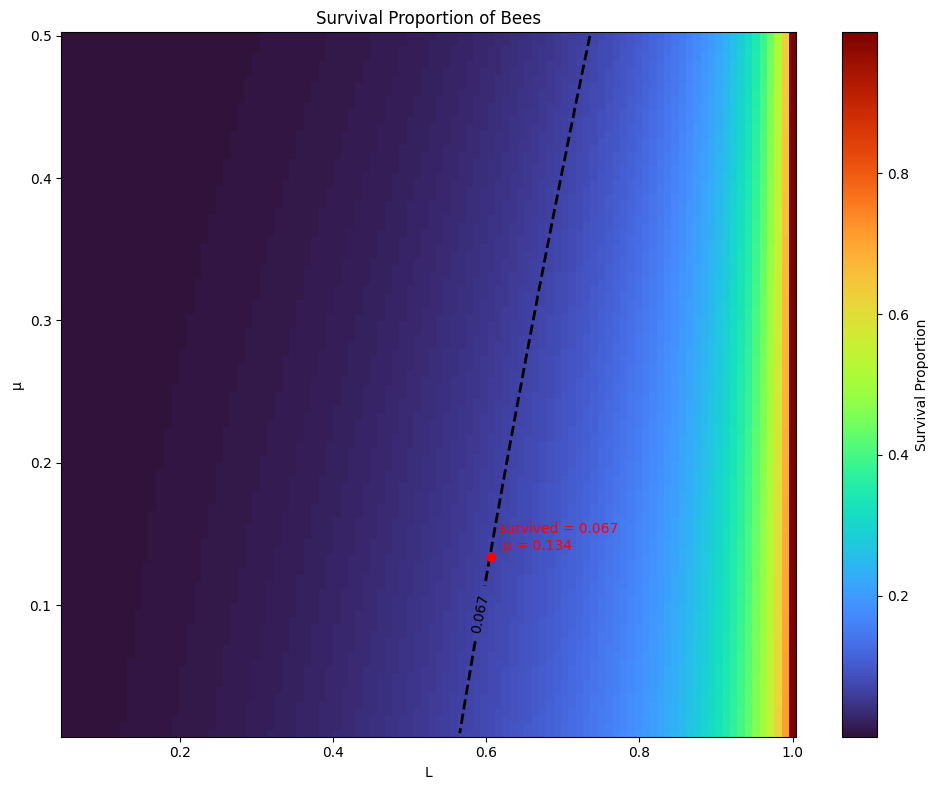

In [12]:
# Heatmap proportion of survived bees (μ, L)
L_vals = np.linspace(0.05, 1.0, 100)
μ_vals = np.linspace(0.01, 0.5, 100)

# Prepare a grid for results
survived_proportion_grid = np.zeros((len(μ_vals), len(L_vals)))

# Fill the grid
for i, L in enumerate(L_vals):
    for j, μ in enumerate(μ_vals):
        try:
            p = solve_p(L)
            X = p / μ
            survived_proportion = (1-μ)**X
            survived_proportion_grid[j, i] = survived_proportion
        except:
            survived_proportion_grid[j, i] = np.nan  # In case of failure

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.pcolormesh(
    L_vals, μ_vals, survived_proportion_grid,
    shading='auto', cmap='turbo'
)

# Add isoline near survived_proportion = 0.067
contour = plt.contour(
    L_vals, μ_vals, survived_proportion_grid,
    levels=[0.067], colors='black', linewidths=2, linestyles='--'
)
plt.clabel(contour, fmt={0.067: '0.067'}, inline=True, fontsize=10)

# Find intersection with  μ = 0.134
mu_target = 0.134
mu_index = np.abs(μ_vals - mu_target).argmin()
row = survived_proportion_grid[mu_index, :]
L_intersect_candidates = L_vals[np.isclose(row, 0.067, atol=0.002)]

# IF there is the intersection - mark the point
if len(L_intersect_candidates) > 0:
    L_cross = L_intersect_candidates[0]
    plt.plot(L_cross, mu_target, 'ro')
    
    # Add the label near the point
    plt.text(L_cross + 0.01, mu_target + 0.005,
             f'survived = 0.067 \n μ = {mu_target:.3f}',
             color='red', fontsize=10)

plt.xlabel('L')
plt.ylabel('μ')
plt.title('Survival Proportion of Bees')
plt.colorbar(heatmap, label='Survival Proportion')
plt.tight_layout()
plt.savefig("first_model_survival_proportion.pdf", format='pdf', bbox_inches='tight')
plt.show()


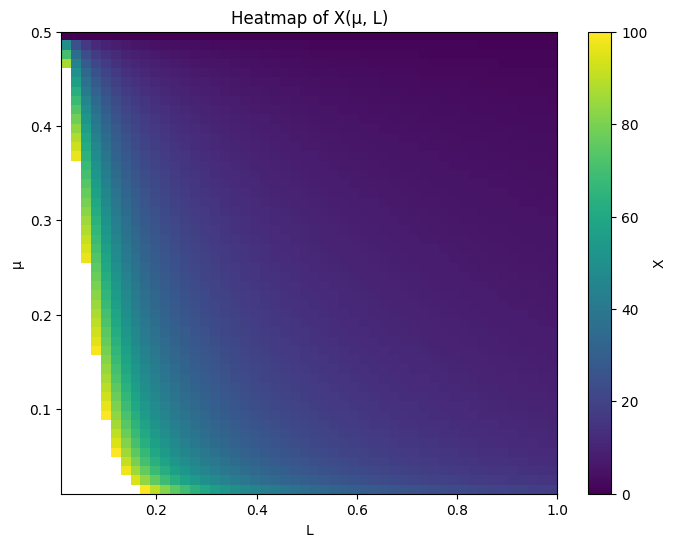

In [13]:
# Grid for μ and L
μ_vals = np.linspace(0.01, 0.5, 50)   
L_vals = np.linspace(0.01, 1, 50)
X_vals = np.zeros((len(L_vals), len(μ_vals)))

# Compute X = p / μ
for j, L in enumerate(L_vals):
    for i, μ in enumerate(μ_vals):
        try:
            p = solve_p(L)
            X_vals[j, i] = p / μ
        except:
            X_vals[j, i] = np.nan  # mark failures

# Create a copy and set values > 100 to NaN
X_plot = X_vals.copy()
X_plot[X_vals > 100] = np.nan

# Create a colormap and set NaN values to white
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Plot heatmap with transposed axes
plt.figure(figsize=(8, 6))
im = plt.imshow(X_plot,  
                extent=[L_vals[0], L_vals[-1], μ_vals[0], μ_vals[-1]],  
                origin='lower',
                aspect='auto', 
                cmap=cmap,
                vmin=0,
                vmax=100)

plt.colorbar(label="X")
plt.xlabel("L")  
plt.ylabel("μ")  
plt.title("Heatmap of X(μ, L)")
plt.savefig("first_model_heatmap_X_from_μ_and_L.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [14]:
X_plot

array([[           nan,            nan,            nan, ...,
        1.87496417e+01, 1.83669959e+01, 1.79996560e+01],
       [           nan,            nan,            nan, ...,
        1.57119733e+01, 1.53913208e+01, 1.50834944e+01],
       [           nan,            nan,            nan, ...,
        1.42362570e+01, 1.39457212e+01, 1.36668068e+01],
       ...,
       [7.04988977e+01, 3.52494488e+01, 2.34996326e+01, ...,
        1.46872703e+00, 1.43875301e+00, 1.40997795e+00],
       [4.95410671e+01, 2.47705336e+01, 1.65136890e+01, ...,
        1.03210556e+00, 1.01104219e+00, 9.90821342e-01],
       [1.00000100e-04, 5.00000500e-05, 3.33333667e-05, ...,
        2.08333542e-06, 2.04081837e-06, 2.00000200e-06]])

Pathogen analysis

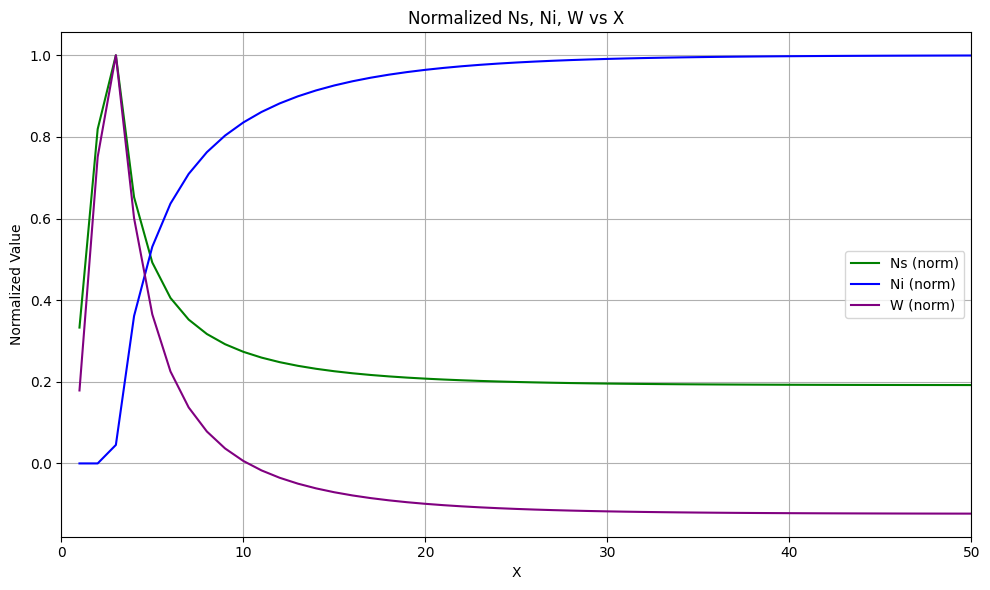

In [15]:
X_range = np.linspace(1, 100, 100)

μ = 0.134
m = 1e-6
v = 0.001

N_vals = []
I_vals = []
n0_vals = []
W_vals = []
for X in X_range:
    p = p_from_X(X)
    I = solve_I(p)
    I_vals.append(I)
    if not np.isnan(I):
        n0_val = n0(p)
        N_val = N_from_n0(n0_val, p, I)
        W_val = W_from_N( N_val, p, I)
    else:
        N_val = np.nan
        n0_val = np.nan
        W_val = np.nan
        
    N_vals.append(N_val)
    n0_vals.append(n0_val)
    W_vals.append(W_val)
    
    
# Convert to numpy arrays
X_array = np.array(X_range)
N_array = np.array(N_vals)
I_array = np.array(I_vals)
W_array = np.array(W_vals)


mask = np.isfinite(N_array) & np.isfinite(I_array) & np.isfinite(W_array)

# Normalisation (divide on max)
N_norm = N_array[mask] / np.nanmax(N_array[mask])
I_norm = I_array[mask] / np.nanmax(I_array[mask])
W_norm = W_array[mask] / np.nanmax(W_array[mask])
X_valid = X_array[mask]

# Building plots
plt.figure(figsize=(10, 6))
plt.plot(X_valid, N_norm, label='Ns (norm)', color='green')
plt.plot(X_valid, I_norm, label='Ni (norm)', color='blue')
plt.plot(X_valid, W_norm, label='W (norm)', color='purple')
plt.xlabel('X')
plt.ylabel('Normalized Value')
plt.title('Normalized Ns, Ni, W vs X')
plt.legend()
plt.xlim(0, 50)
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_normalized_Ni_Ns_W_vs_X_optim_5.pdf", format='pdf', bbox_inches='tight')
plt.show()

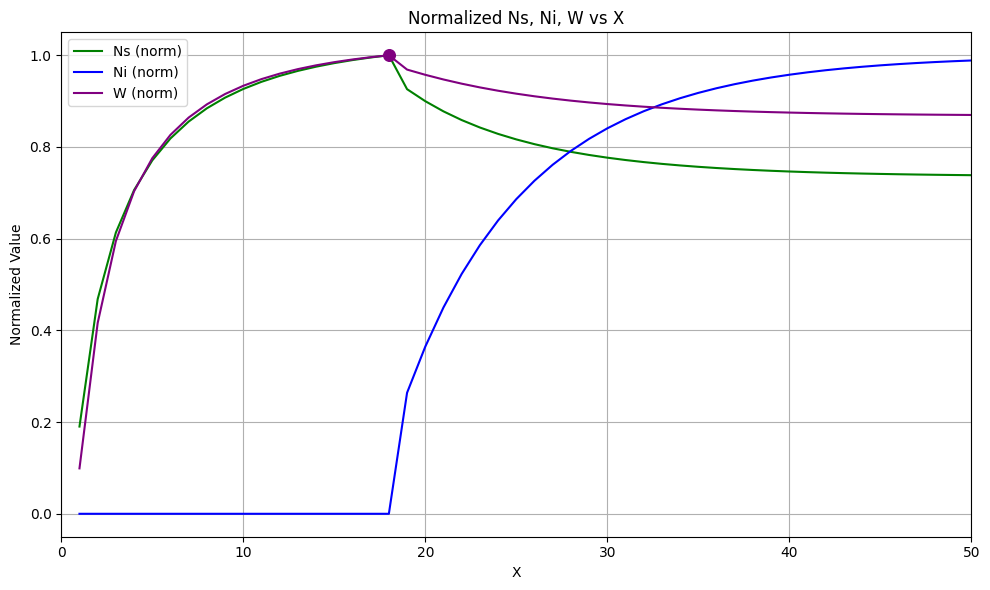

In [16]:
X_range = np.linspace(1, 100, 100)

μ = 0.134
m = 1e-6
v = 0.000149

N_vals = []
I_vals = []
n0_vals = []
W_vals = []
for X in X_range:
    p = p_from_X(X)
    I = solve_I(p)
    I_vals.append(I)
    if not np.isnan(I):
        n0_val = n0(p)
        N_val = N_from_n0(n0_val, p, I)
        W_val = W_from_N( N_val, p, I)
    else:
        N_val = np.nan
        n0_val = np.nan
        W_val = np.nan
        
    N_vals.append(N_val)
    n0_vals.append(n0_val)
    W_vals.append(W_val)
    
    
# Convert to numpy arrays
X_array = np.array(X_range)
N_array = np.array(N_vals)
I_array = np.array(I_vals)
W_array = np.array(W_vals)


mask = np.isfinite(N_array) & np.isfinite(I_array) & np.isfinite(W_array)

# Normalisation (divide on max)
N_norm = N_array[mask] / np.nanmax(N_array[mask])
I_norm = I_array[mask] / np.nanmax(I_array[mask])
W_norm = W_array[mask] / np.nanmax(W_array[mask])
X_valid = X_array[mask]


# --- Add marker at X=18 ---
X_point = 18
# Interpolated values at X=18
N_point = np.interp(X_point, X_valid, N_norm)
I_point = np.interp(X_point, X_valid, I_norm)
W_point = np.interp(X_point, X_valid, W_norm)


# Building plots
plt.figure(figsize=(10, 6))
plt.plot(X_valid, N_norm, label='Ns (norm)', color='green')
plt.plot(X_valid, I_norm, label='Ni (norm)', color='blue')
plt.plot(X_valid, W_norm, label='W (norm)', color='purple')

# Mark the point X=18
plt.scatter(X_point, W_point, color='purple', marker='o', s=70, zorder=5)

plt.xlabel('X')
plt.ylabel('Normalized Value')
plt.title('Normalized Ns, Ni, W vs X')
plt.legend()
plt.xlim(0, 50)
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_normalized_Ni_Ns_W_vs_X_optim_18.pdf", format='pdf', bbox_inches='tight')
plt.show()

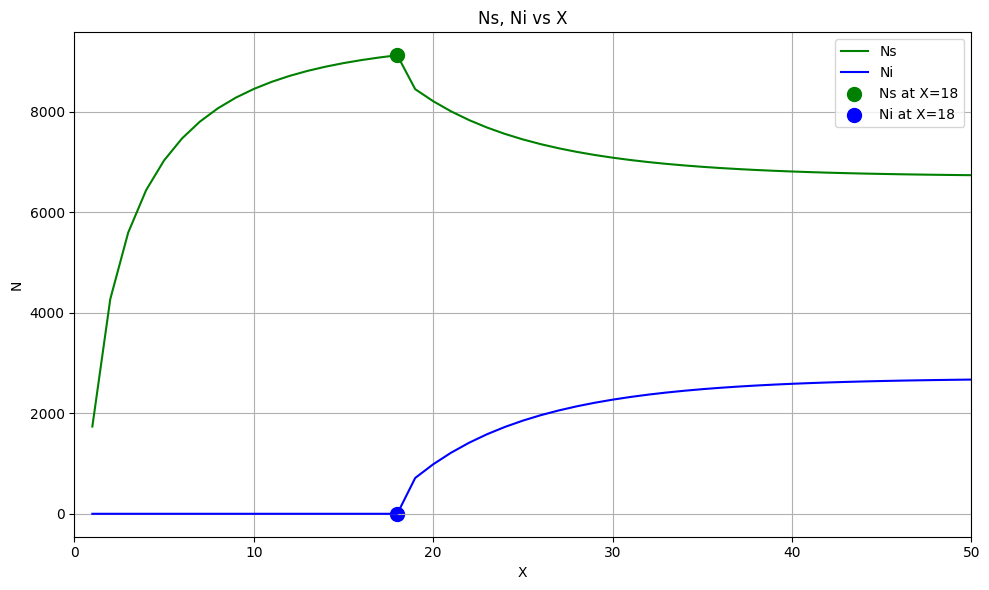

In [17]:
X_range = np.linspace(1, 100, 100)

μ = 0.134
m = 1e-6
v = 0.000149

N_vals = []
I_vals = []
n0_vals = []
for X in X_range:
    p = p_from_X(X)
    I = solve_I(p)
    I_vals.append(I)
    if not np.isnan(I):
        n0_val = n0(p)
        N_val = N_from_n0(n0_val, p, I)
        W_val = W_from_N(N_val, p, I)
    else:
        N_val = np.nan
        n0_val = np.nan
        W_val = np.nan
        
    N_vals.append(N_val)
    n0_vals.append(n0_val)
    
# Convert to numpy arrays
X_array = np.array(X_range)
N_array = np.array(N_vals)
I_array = np.array(I_vals)

# --- Add marker at X=18 ---
X_point = 18
p_point = p_from_X(X_point)
I_point = solve_I(p_point)
if not np.isnan(I_point):
    n0_point = n0(p_point)
    N_point = N_from_n0(n0_point, p_point, I_point)
else:
    I_point, N_point = np.nan, np.nan

# Building plots
plt.figure(figsize=(10, 6))
plt.plot(X_array, N_array, label='Ns', color='green')
plt.plot(X_array, I_array, label='Ni', color='blue')

# Add markers
plt.scatter([X_point], [N_point], color='green', marker='o', s=100, label='Ns at X=18')
plt.scatter([X_point], [I_point], color='blue', marker='o', s=100, label='Ni at X=18')

plt.xlabel('X')
plt.ylabel('N')
plt.title('Ns, Ni vs X')
plt.legend()
plt.xlim(0, 50)
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_Ni_Ns_vs_X_optim_18.pdf", format='pdf', bbox_inches='tight')
plt.show()


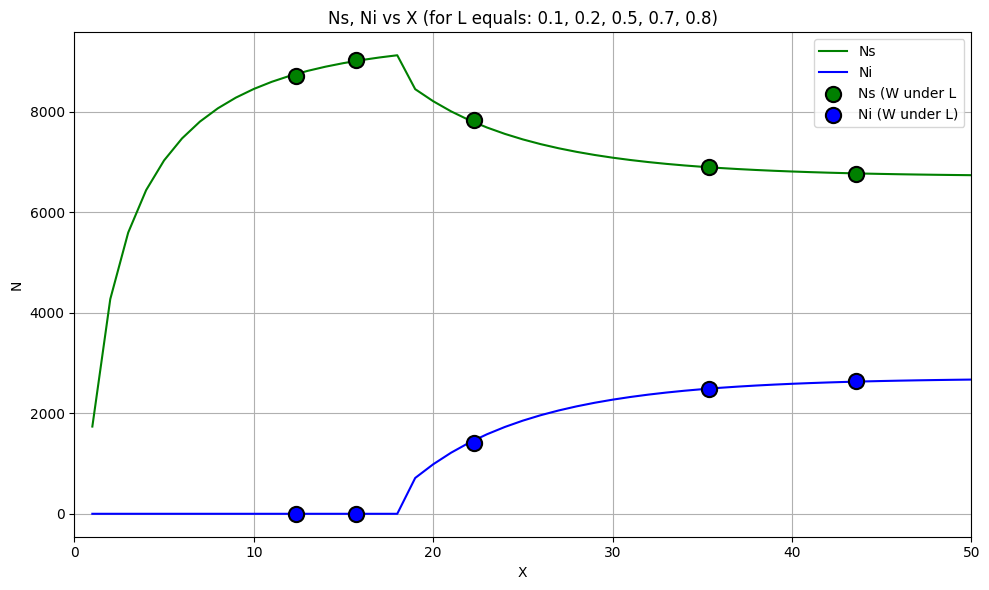

In [18]:
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
L_vals = [0.1, 0.2, 0.5, 0.7, 0.8]

X_list = []
W_list = []

for L in L_vals:
    try:
        p = solve_p(L)  # your function
        X = p / μ
        I = solve_I(p)  # your function
        if not np.isnan(I):
            n0_val = n0(p)  # your function
            N_val = N_from_n0(n0_val, p, I)  # your function
            W_val = W_from_N(N_val, p, I)  # your function
            
            X_list.append(X)
            W_list.append(W_val)
    except ValueError:
        continue 
    
# --- Curve data ---
X_range = np.linspace(1, 100, 100)
m = 1e-6
v = 0.000149

N_vals = []
I_vals = []
W_curve = []

for X in X_range:
    p = p_from_X(X)
    I = solve_I(p)
    I_vals.append(I)
    if not np.isnan(I):
        n0_val = n0(p)
        N_val = N_from_n0(n0_val, p, I)
        W_val = W_from_N(N_val, p, I)
    else:
        N_val = np.nan
        W_val = np.nan
    N_vals.append(N_val)
    W_curve.append(W_val)

# Convert to numpy arrays
X_array = np.array(X_range)
N_array = np.array(N_vals)
I_array = np.array(I_vals)
W_array = np.array(W_list)

X_points = X_list[:]

# Find corresponding N and I on the curves
N_points = []
I_points = []
for xp in X_points:
    idx = np.argmin(np.abs(X_array - xp))  # nearest X on curve
    N_points.append(N_array[idx])
    I_points.append(I_array[idx])

# ==== Plot ====
plt.figure(figsize=(10, 6))
plt.plot(X_array, N_array, label='Ns', color='green')
plt.plot(X_array, I_array, label='Ni', color='blue')

# Markers for top-5 W
plt.scatter(X_points, N_points, color='green', s=120, zorder=3, marker='o',
            edgecolors='black', linewidths=1.5, label='Ns (W under L')
plt.scatter(X_points, I_points, color='blue', s=120, zorder=3, marker='o',
            edgecolors='black', linewidths=1.5, label='Ni (W under L)')

plt.xlabel('X')
plt.ylabel('N')
plt.title('Ns, Ni vs X (for L equals: 0.1, 0.2, 0.5, 0.7, 0.8)')
plt.legend()
plt.xlim(0, 50)
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_Ni_Ns_vs_X_different_L.pdf", format='pdf', bbox_inches='tight')
plt.show()


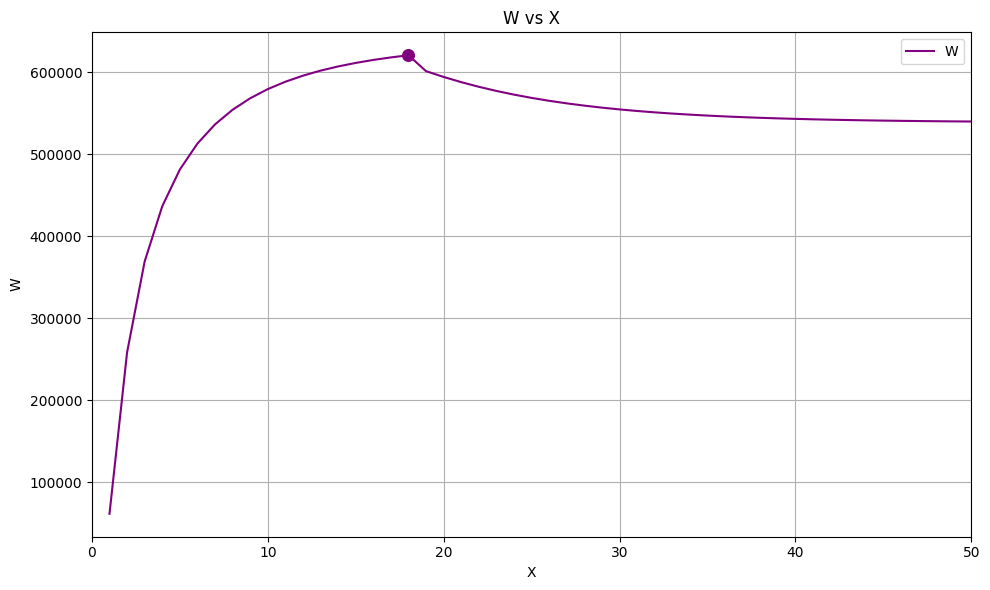

In [19]:
X_range = np.linspace(1, 100, 100)

μ = 0.134
m = 1e-6
v = 0.000149

W_vals = []
for X in X_range:
    p = p_from_X(X)
    I = solve_I(p)
    if not np.isnan(I):
        n0_val = n0(p)
        N_val = N_from_n0(n0_val, p, I)
        W_val = W_from_N(N_val, p, I)
    else:
        W_val = np.nan
        
    W_vals.append(W_val)
    
# Convert to numpy arrays
X_array = np.array(X_range)
W_array = np.array(W_vals)

# --- Marker at X=18 (compute from formulas, not interpolation) ---
X_point = 18
p_point = p_from_X(X_point)
I_point = solve_I(p_point)
if not np.isnan(I_point):
    n0_point = n0(p_point)
    N_point = N_from_n0(n0_point, p_point, I_point)
    W_point = W_from_N(N_point, p_point, I_point)
else:
    W_point = np.nan

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(X_array, W_array, label='W', color='purple')
# Mark the point X=18
plt.scatter(X_point, W_point, color='purple', marker='o', s=70, zorder=5)

plt.xlabel('X')
plt.ylabel('W')
plt.title('W vs X')
plt.legend()
plt.xlim(0, 50)
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_W_vs_X_optim_18.pdf", format='pdf', bbox_inches='tight')
plt.show()


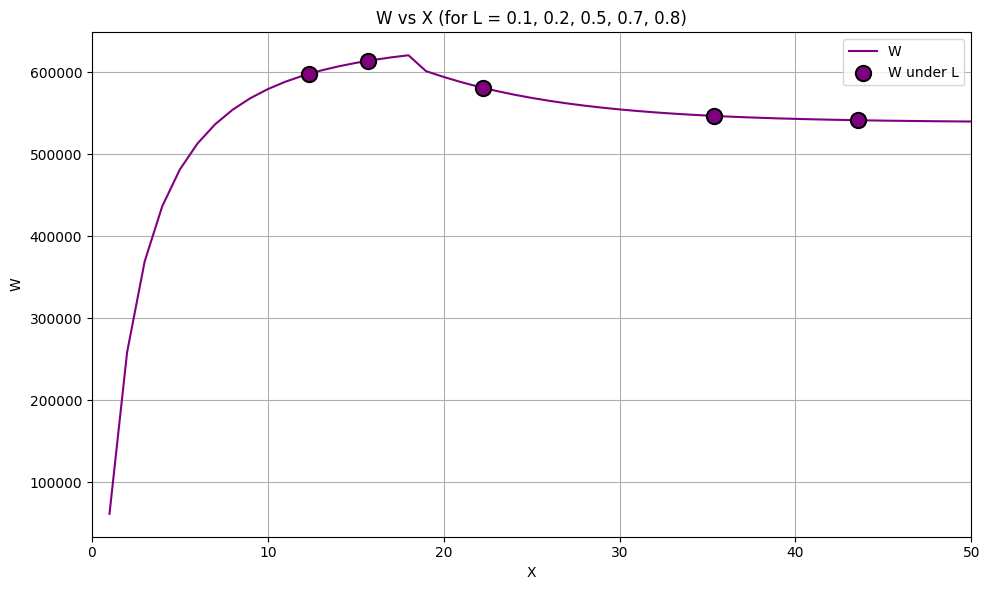

In [20]:
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
L_vals = [0.1, 0.2, 0.5, 0.7, 0.8]

X_list = []
W_list = []

# Compute special points for given L
for L in L_vals:
    try:
        p = solve_p(L)  # your function
        X = p / μ
        I = solve_I(p)  # your function
        if not np.isnan(I):
            n0_val = n0(p)  # your function
            N_val = N_from_n0(n0_val, p, I)  # your function
            W_val = W_from_N(N_val, p, I)  # your function
            
            X_list.append(X)
            W_list.append(W_val)
    except ValueError:
        continue 
    
# --- Curve data ---
X_range = np.linspace(1, 100, 100)
m = 1e-6
v = 0.000149

W_curve = []
for X in X_range:
    p = p_from_X(X)
    I = solve_I(p)
    if not np.isnan(I):
        n0_val = n0(p)
        N_val = N_from_n0(n0_val, p, I)
        W_val = W_from_N(N_val, p, I)
    else:
        W_val = np.nan
    W_curve.append(W_val)

# Convert to numpy arrays
X_array = np.array(X_range)
W_curve = np.array(W_curve)

# ==== Plot ====
plt.figure(figsize=(10, 6))
plt.plot(X_array, W_curve, label='W', color='purple')

# Markers for the 5 L values
plt.scatter(X_list, W_list, color='purple', s=120, zorder=3, marker='o',
            edgecolors='black', linewidths=1.5, label='W under L')


plt.xlabel('X')
plt.ylabel('W')
plt.title('W vs X (for L = 0.1, 0.2, 0.5, 0.7, 0.8)')
plt.legend()
plt.xlim(0, 50)
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_W_vs_X_different_L.pdf", format='pdf', bbox_inches='tight')
plt.show()


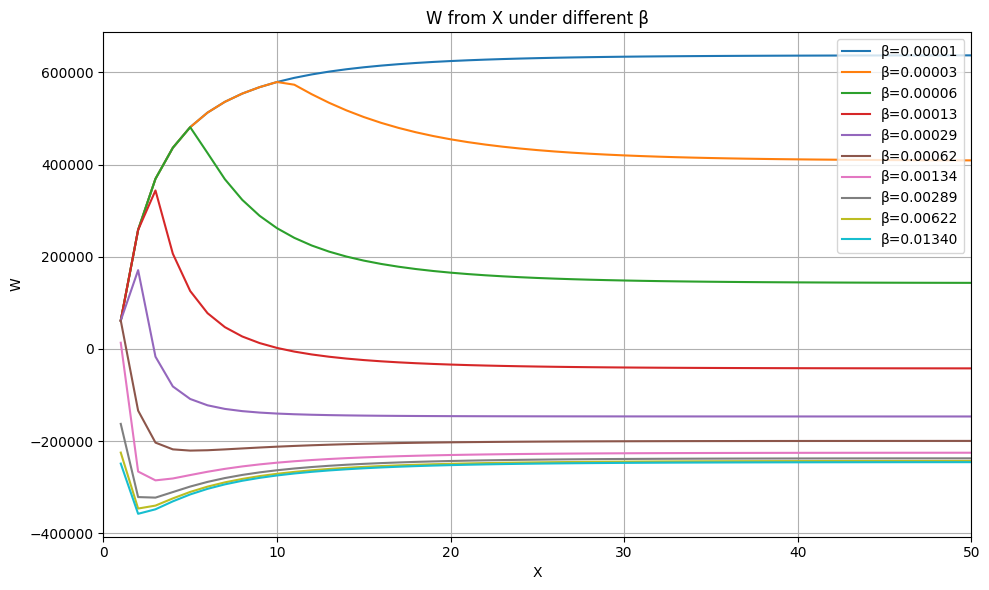

In [21]:
μ = 0.134
m = 1e-6

X_range = np.linspace(1, 100, 100)

M = 5     
F = 3     
C = 137    
S0 = 230.25

alpha = (M + F) / S0
beta = (μ * C) / S0

plt.figure(figsize=(10, 6))
v_values = np.logspace(-4, -1, 10)

for v in v_values:
    W_vals = []
    for X in X_range:
        p = p_from_X(X)
        I = solve_I_v(p, v)
        if not np.isnan(I):
            n0_val = n0(p)
            N_val = N_from_n0_v(n0_val, p, I, v)
            W_val = W_from_N(N_val, p, I)
        else:
            W_val = np.nan
        W_vals.append(W_val)
    β_param = v * μ  # convert to β
    plt.plot(X_range, W_vals, label=f"β={β_param:.5f}")

plt.xlabel("X")
plt.ylabel("W")
plt.title("W from X under different β")
plt.legend()
plt.xlim(0, 50)
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_w(x)_different_β.pdf", format='pdf', bbox_inches='tight')
plt.show()


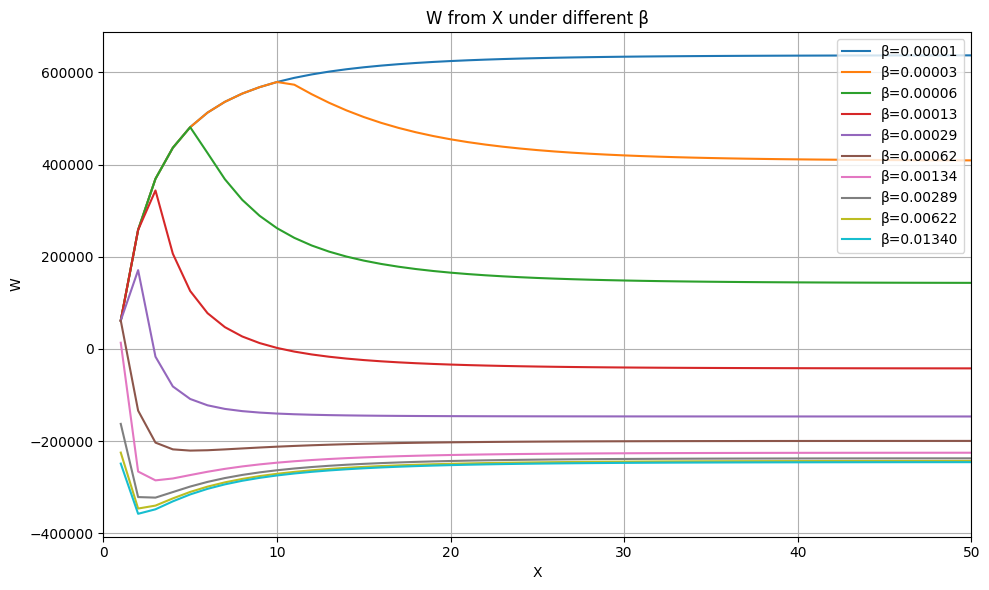

In [22]:
μ = 0.134
m = 1e-6

X_range = np.linspace(1, 100, 100)

M = 5     
F = 3     
C = 137    
S0 = 230.25

alpha = (M + F) / S0
beta = (μ * C) / S0

plt.figure(figsize=(10, 6))
v_values = np.logspace(-4, -1, 10)

for v in v_values:
    W_vals = []
    for X in X_range:
        p = p_from_X(X)
        I = solve_I_v(p, v)
        if not np.isnan(I):
            n0_val = n0(p)
            N_val = N_from_n0_v(n0_val, p, I, v)
            W_val = W_from_Xn0(N_val, p, I, n0_val)
        else:
            W_val = np.nan
        W_vals.append(W_val)
    β_param = v * μ  # convert to β
    plt.plot(X_range, W_vals, label=f"β={β_param:.5f}")

plt.xlabel("X")
plt.ylabel("W")
plt.title("W from X under different β")
plt.legend()
plt.xlim(0, 50)
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_w(x)_different_β_n0_as_parameter.pdf", format='pdf', bbox_inches='tight')
plt.show()

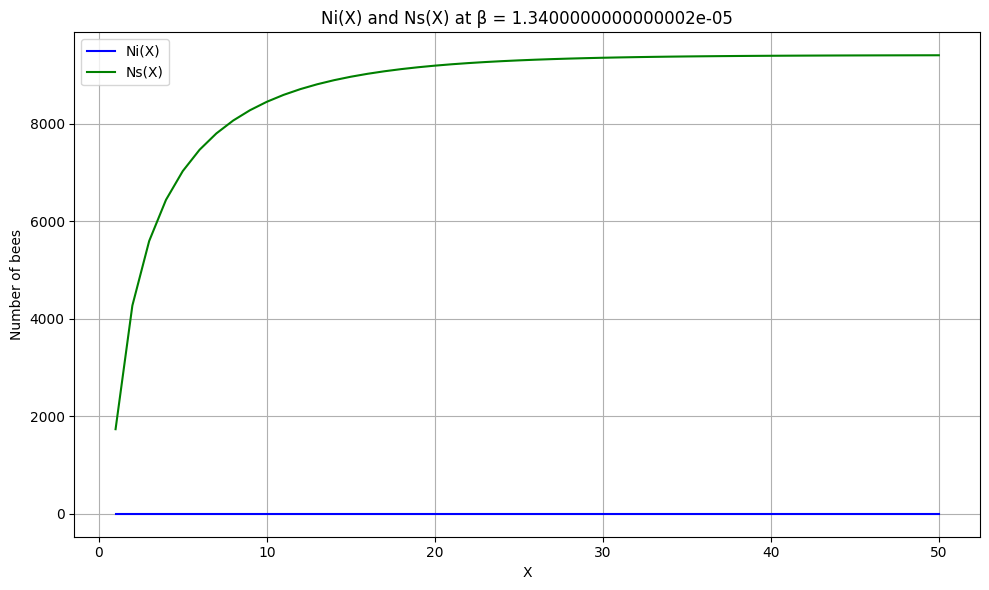

In [23]:
import numpy as np
import matplotlib.pyplot as plt


μ = 0.134
m = 1e-6
v = 0.0001 # how fast the pathogen spreads

M = 5     
F = 3     
C = 137    
S0 = 230.25

alpha = (M + F) / S0
beta = (μ * C) / S0

# Countings
X_range = np.arange(1, 51)
I_vals = []
N_vals = []

for X in X_range:
    p = p_from_X(X)
    I = solve_I(p)
    if np.isnan(I):
        I_vals.append(np.nan)
        N_vals.append(np.nan)
    else:
        I_vals.append(I)
        n0_val = n0(p)
        N = N_from_n0(n0_val, p, I)
        N_vals.append(N)

# Building plots
plt.figure(figsize=(10, 6))
plt.plot(X_range, I_vals, label='Ni(X)', color='blue')
plt.plot(X_range, N_vals, label='Ns(X)', color='green')
plt.xlabel('X')
plt.ylabel('Number of bees')
plt.title(f'Ni(X) and Ns(X) at β = {v * μ}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_Ni_Ns_from_X_β=0.00074.pdf", format='pdf', bbox_inches='tight')
plt.show()

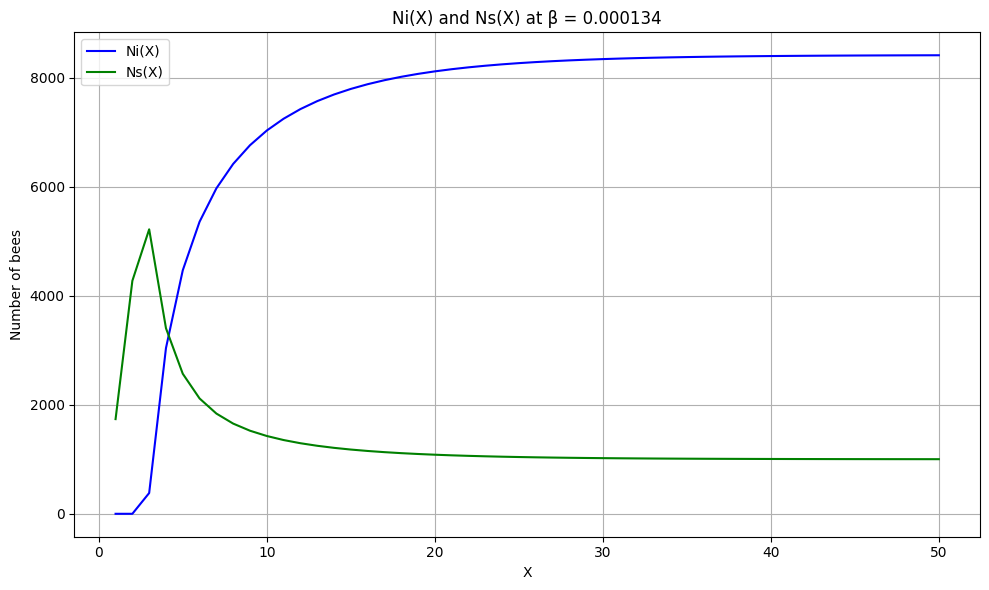

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
μ = 0.134
m = 1e-6
v = 0.001

M = 5     
F = 3     
C = 137    
S0 = 230.25

alpha = (M + F) / S0
beta = (μ * C) / S0

# Countings
X_range = np.arange(1, 51)
I_vals = []
N_vals = []

for X in X_range:
    p = p_from_X(X)
    I = solve_I(p)
    if np.isnan(I):
        I_vals.append(np.nan)
        N_vals.append(np.nan)
    else:
        I_vals.append(I)
        n0_val = n0(p)
        N = N_from_n0(n0_val, p, I)
        N_vals.append(N)

# Building plots
plt.figure(figsize=(10, 6))
plt.plot(X_range, I_vals, label='Ni(X)', color='blue')
plt.plot(X_range, N_vals, label='Ns(X)', color='green')
plt.xlabel('X')
plt.ylabel('Number of bees')
plt.title(f'Ni(X) and Ns(X) at β = {v * μ}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_Ni_Ns_from_X_β=0.0074.pdf", format='pdf', bbox_inches='tight')
plt.show()

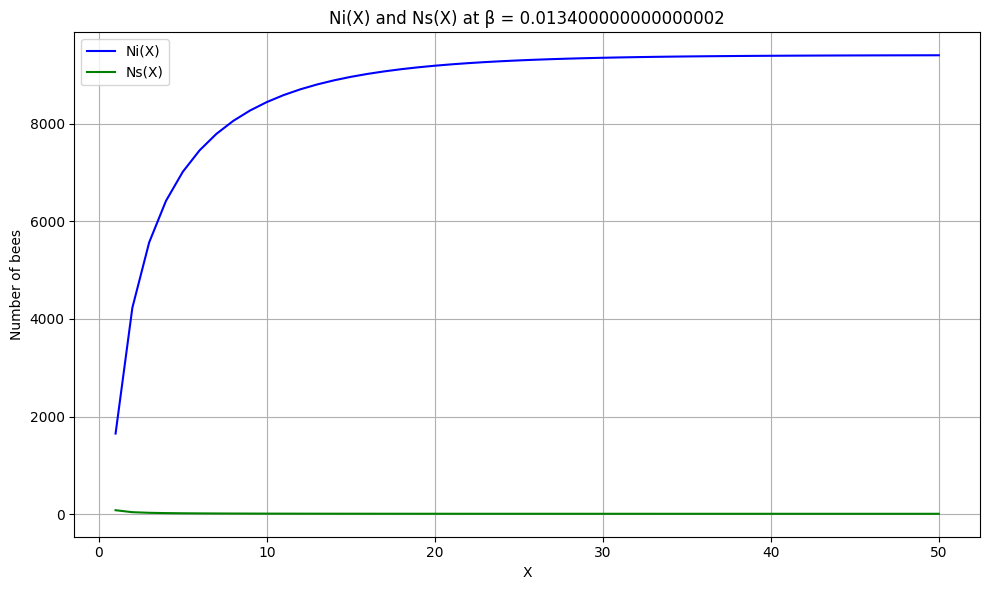

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
μ = 0.134
m = 1e-6
v = 0.1

M = 5     
F = 3     
C = 137    
S0 = 230.25

alpha = (M + F) / S0
beta = (μ * C) / S0

# Countings
X_range = np.arange(1, 51)
I_vals = []
N_vals = []

for X in X_range:
    p = p_from_X(X)
    I = solve_I(p)
    if np.isnan(I):
        I_vals.append(np.nan)
        N_vals.append(np.nan)
    else:
        I_vals.append(I)
        n0_val = n0(p)
        N = N_from_n0(n0_val, p, I)
        N_vals.append(N)

# Building plots
plt.figure(figsize=(10, 6))
plt.plot(X_range, I_vals, label='Ni(X)', color='blue')
plt.plot(X_range, N_vals, label='Ns(X)', color='green')
plt.xlabel('X')
plt.ylabel('Number of bees')
plt.title(f'Ni(X) and Ns(X) at β = {v * μ}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("third_model_Ni_Ns_from_X_β=0.74.pdf", format='pdf', bbox_inches='tight')
plt.show()

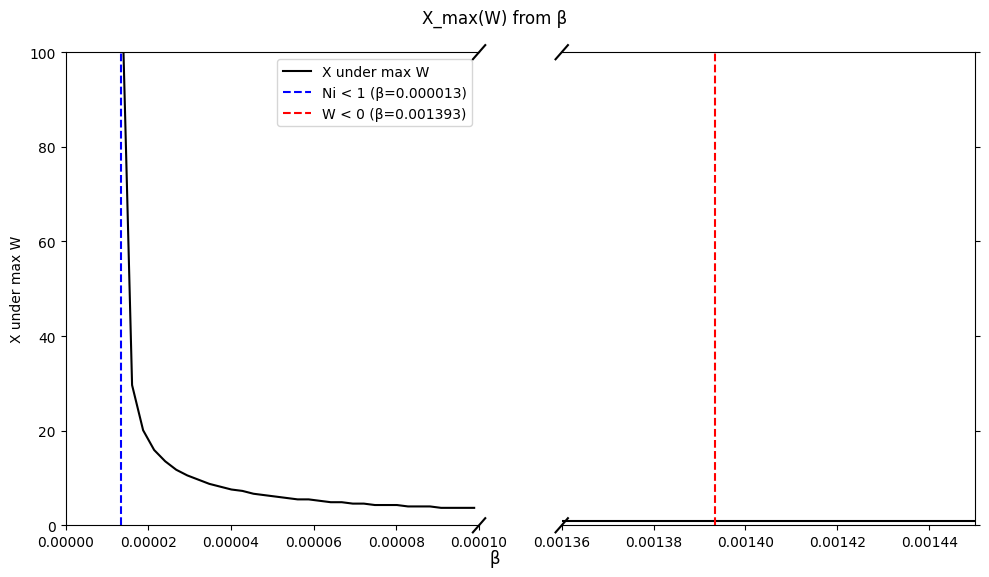

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# initial values
μ = 0.134
m = 1e-6
M = 5     
F = 3     
C = 137    
S0 = 230.25
alpha = (M + F) / S0
beta = (μ * C) / S0

X_range = np.linspace(1, 120, 400)
v_values = np.linspace(0.0001, 0.02, 1000)

X_maxima = []
filtered_β = []
W_maxima = []

β_max_all_I_below_1 = None
β_first_W_negative = None

# counting
for v in v_values:
    W_vals = []
    I_vals = []

    for X in X_range:
        p = p_from_X(X)
        I = solve_I_v(p, v)
        if not np.isnan(I):
            n0_val = n0(p)
            N_val = N_from_n0_v(n0_val, p, I, v)
            W_val = W_from_N(N_val, p, I)
        else:
            W_val = np.nan
        W_vals.append(W_val)
        I_vals.append(I)

    β = v * μ  # convert v to β

    if all([not np.isnan(I) and I < 1 for I in I_vals]):
        β_max_all_I_below_1 = β

    if not all(np.isnan(W_vals)):
        max_idx = np.nanargmax(W_vals)
        max_W = W_vals[max_idx]
        max_X = X_range[max_idx]

        if β_first_W_negative is None and max_W < 0:
            β_first_W_negative = β

        if max_W:
            filtered_β.append(β)
            X_maxima.append(max_X)
            W_maxima.append(max_W)

# Divide data on the right and left parts
β_left = [β for β in filtered_β if β < 0.0001]
X_left = [X_maxima[i] for i, β in enumerate(filtered_β) if β < 0.0001]

β_right = [β for β in filtered_β if β >= 0.00016]
X_right = [X_maxima[i] for i, β in enumerate(filtered_β) if β >= 0.00016]

# Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

# The left part
ax1.plot(β_left, X_left, color='black', label="X under max W")
if β_max_all_I_below_1 is not None and β_max_all_I_below_1 < 0.00016:
    ax1.axvline(x=β_max_all_I_below_1, color='blue', linestyle='--', 
                label=f'Ni < 1 (β={β_max_all_I_below_1:.6f})')

# The right part
ax2.plot(β_right, X_right, color='black')

if β_first_W_negative is not None:
    ax2.axvline(x=β_first_W_negative, color='red', linestyle='--', 
                label=f'W < 0 (β={β_first_W_negative:.6f})')

# Axes setting
ax1.set_xlim(0, (0.0001))
ax2.set_xlim((0.00136), (0.00145))
ax1.set_ylim(0, 100)

f.supxlabel("β", fontsize=12, y=0.05)
ax1.set_ylabel("X under max W")
f.suptitle("X_max(W) from β")

# Delete spines between the subplots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Legend
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + handles2, labels + labels2, loc='upper right')

plt.tight_layout()

# Format axes
formatter = FuncFormatter(lambda x, _: f"{x:.5f}")
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_formatter(formatter)

ax1.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax2.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.savefig("third_model_X_max(W)_from_β_discontinuous.pdf", format='pdf', bbox_inches='tight')
plt.subplots_adjust(wspace=0.2)
plt.show()


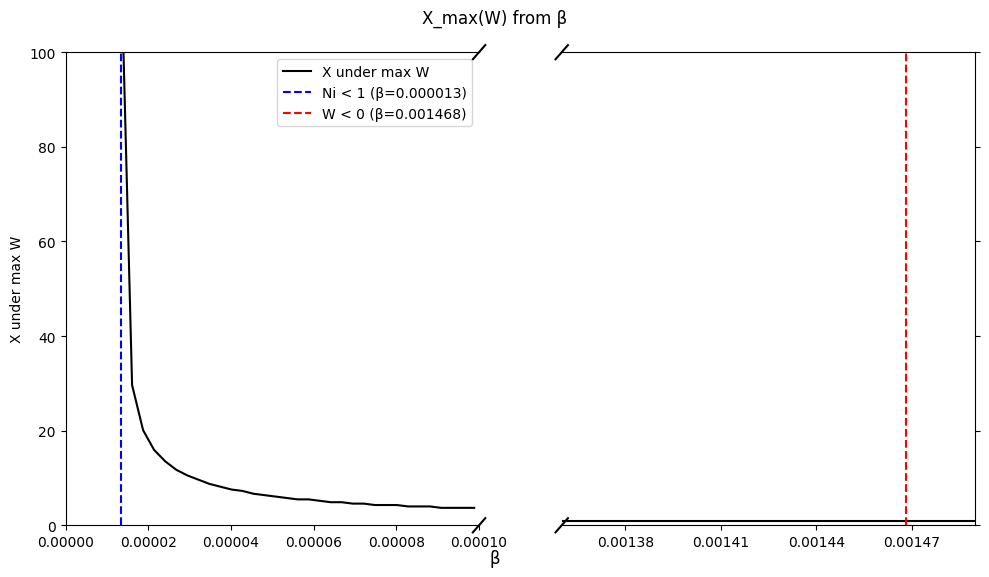

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# initial values
μ = 0.134
m = 1e-6
M = 5     
F = 3     
C = 137    
S0 = 230.25
alpha = (M + F) / S0
beta = (μ * C) / S0

X_range = np.linspace(1, 120, 400)
v_values = np.linspace(0.0001, 0.02, 1000)
n0_range = np.linspace(1, 10000, 100)  # Create n0 linspace

X_maxima = []
filtered_β = []
W_maxima = []

β_max_all_I_below_1 = None
β_first_W_negative = None

# counting
for v in v_values:
    W_vals = []
    I_vals = []

    for X in X_range:
        p = p_from_X(X)
        I = solve_I_v(p, v)
        if not np.isnan(I):
            # Loop over n0 values and find maximum W
            max_W_for_X = np.nan
            for n0_val in n0_range:
                N_val = N_from_n0_v(n0_val, p, I, v)
                W_val = W_from_Xn0(N_val, p, I, n0_val)
                if np.isnan(max_W_for_X) or (not np.isnan(W_val) and W_val > max_W_for_X):
                    max_W_for_X = W_val
            W_vals.append(max_W_for_X)
        else:
            W_vals.append(np.nan)
        I_vals.append(I)

    β = v * μ  # convert v to β

    if all([not np.isnan(I) and I < 1 for I in I_vals]):
        β_max_all_I_below_1 = β

    if not all(np.isnan(W_vals)):
        max_idx = np.nanargmax(W_vals)
        max_W = W_vals[max_idx]
        max_X = X_range[max_idx]

        if β_first_W_negative is None and max_W < 0:
            β_first_W_negative = β

        if max_W:
            filtered_β.append(β)
            X_maxima.append(max_X)
            W_maxima.append(max_W)

# Divide data on the right and left parts
β_left = [β for β in filtered_β if β < 0.0001]
X_left = [X_maxima[i] for i, β in enumerate(filtered_β) if β < 0.0001]

β_right = [β for β in filtered_β if β >= 0.00016]
X_right = [X_maxima[i] for i, β in enumerate(filtered_β) if β >= 0.00016]

# Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

# The left part
ax1.plot(β_left, X_left, color='black', label="X under max W")
if β_max_all_I_below_1 is not None and β_max_all_I_below_1 < 0.00016:
    ax1.axvline(x=β_max_all_I_below_1, color='blue', linestyle='--', 
                label=f'Ni < 1 (β={β_max_all_I_below_1:.6f})')

# The right part
ax2.plot(β_right, X_right, color='black')

if β_first_W_negative is not None:
    ax2.axvline(x=β_first_W_negative, color='red', linestyle='--', 
                label=f'W < 0 (β={β_first_W_negative:.6f})')

# Axes setting
ax1.set_xlim(0, (0.0001))
ax2.set_xlim((0.00136), (0.00149))
ax1.set_ylim(0, 100)

f.supxlabel("β", fontsize=12, y=0.05)
ax1.set_ylabel("X under max W")
f.suptitle("X_max(W) from β")

# Delete spines between the subplots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Legend
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + handles2, labels + labels2, loc='upper right')

plt.tight_layout()

# Format axes
formatter = FuncFormatter(lambda x, _: f"{x:.5f}")
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_formatter(formatter)

ax1.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax2.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.savefig("third_model_X_max(W)_from_β_discontinuous_n0_as_parameter.pdf", format='pdf', bbox_inches='tight')
plt.subplots_adjust(wspace=0.2)
plt.show()

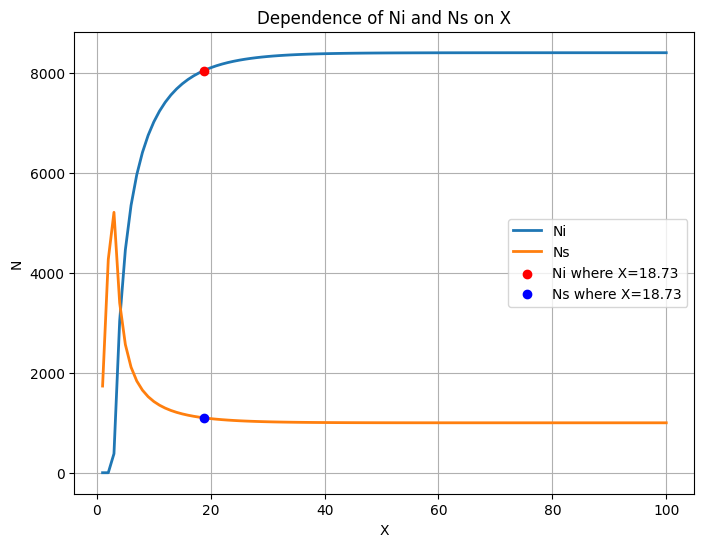

In [28]:
# p=2.5101, X=18.7319 under μ = 0.134

X_range = np.linspace(1, 100, 100)

μ = 0.134
m = 1e-6
v = 0.001

Ns_list = []
Ni_list = []
n0_list = []

for X in X_range:
    p = p_from_X(X)
    Ni = solve_I(p)
    Ni_list.append(Ni)
    if not np.isnan(Ni):
        n0_Val = n0(p)
        Ns_Val = N_from_n0(n0_Val, p, Ni)
        
    else:
        Ns_Val = np.nan
        n0_Val = np.nan
        
    Ns_list.append(Ns_Val)
    n0_list.append(n0_Val)
    
# Plot
plt.figure(figsize=(8,6))
plt.plot(X_range, Ni_list, label="Ni", linewidth=2)
plt.plot(X_range, Ns_list, label="Ns", linewidth=2)
plt.xlabel("X")
plt.ylabel("N")
plt.title("Dependence of Ni and Ns on X")

X_special = 18.7319
p_special = 2.5101
Ni_special = solve_I(p_special)
n0_special = n0(p_special)
Ns_special = N_from_n0(n0_special, p_special, Ni_special)

# Add special point markers
plt.scatter(X_special, Ni_special, color="red", zorder=5, label="Ni where X=18.73")
plt.scatter(X_special, Ns_special, color="blue", zorder=5, label="Ns where X=18.73")

plt.legend()
plt.grid(True)
plt.show()

In [29]:
from scipy.optimize import brentq

μ = 0.134
m = 1e-6
v = 0.001
M = 5     
F = 3     
C = 137    
S0 = 230.25
L = 0.5
β = 0.001
𝜈 = β / μ
𝜆 = (M + F) / S0
γ = (μ * C) / S0

def f_of_p(p, nu, m, S0, lam, gamma):
    e = np.exp(-p)
    denom = 1.0 - e
    # guard tiny denom
    if denom <= 0.0:
        return np.inf
    inner = lam + gamma / denom
    if inner <= 0.0:
        return np.inf
    frac = (1.0 - (p + 1.0) * e) / denom
    return -(nu / (m * S0)) * frac * np.log(inner) - 1.0

def solve_p_from_params_third_model(nu, m, S0, lam, gamma, p_lo=1e-6, p_hi=100.0):
    # expand the upper bound until we bracket a sign change, or give up
    flo = f_of_p(p_lo, nu, m, S0, lam, gamma)
    fhi = f_of_p(p_hi, nu, m, S0, lam, gamma)
    tries = 0
    while np.sign(flo) == np.sign(fhi) and tries < 20:
        p_hi *= 2.0
        fhi = f_of_p(p_hi, nu, m, S0, lam, gamma)
        tries += 1
    if np.isfinite(flo) and np.isfinite(fhi) and np.sign(flo) != np.sign(fhi):
        return brentq(f_of_p, p_lo, p_hi, args=(nu, m, S0, lam, gamma))
    else:
        raise RuntimeError("Could not bracket a root for p. Check parameters.")


first_model_p = solve_p(L)
third_model_p = solve_p_from_params_third_model(μ, m, S0, 𝜆, γ)


Sensitivity analysis for different parameters in pathogen model

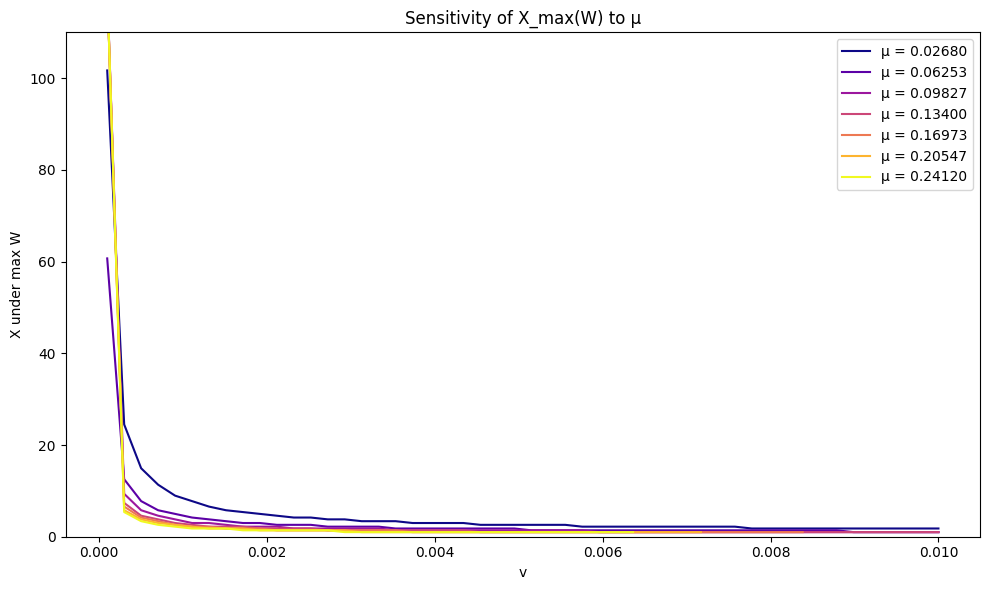

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# sensitivity analysis for μ
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25
X_range = np.linspace(1, 120, 300)
v_values = np.linspace(0.0001, 0.01, 50)

# create 7 μ from -50% to +50%
μ_base = 0.134
μ_values = np.linspace(μ_base * 0.2, μ_base * 1.8, 7)
colors = plt.cm.plasma(np.linspace(0, 1, len(μ_values)))
labels = [f"μ = {μ:.5f}" for μ in μ_values]

plt.figure(figsize=(10, 6))

for μ, color, label in zip(μ_values, colors, labels):
    alpha = (M + F) / S0
    beta = (μ * C) / S0

    X_maxima = []
    filtered_v = []

    for v in v_values:
        W_vals = []

        for X in X_range:
            p = X * μ
            try:
                n0_val = n0(p)
                I = solve_I_v(p, v)
                if np.isnan(I):
                    W_val = np.nan
                else:
                    N_val = N_from_n0_v(n0_val, p, I, v)
                    W_val = W_from_N(N_val, p, I)
            except:
                W_val = np.nan

            W_vals.append(W_val)

        if not all(np.isnan(W_vals)):
            max_idx = np.nanargmax(W_vals)
            max_X = X_range[max_idx]
            max_W = W_vals[max_idx]

            if max_W >= 0:
                filtered_v.append(v)
                X_maxima.append(max_X)

    
    plt.plot(filtered_v, X_maxima, linestyle='-', marker='', color=color, label=label)

plt.ylim(0, 110)
plt.xlabel("v")
plt.ylabel("X under max W")
plt.title("Sensitivity of X_max(W) to μ")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig("third_model_sensitivity_Xmax(W)_to_μ.pdf", format='pdf', bbox_inches='tight')
plt.show()


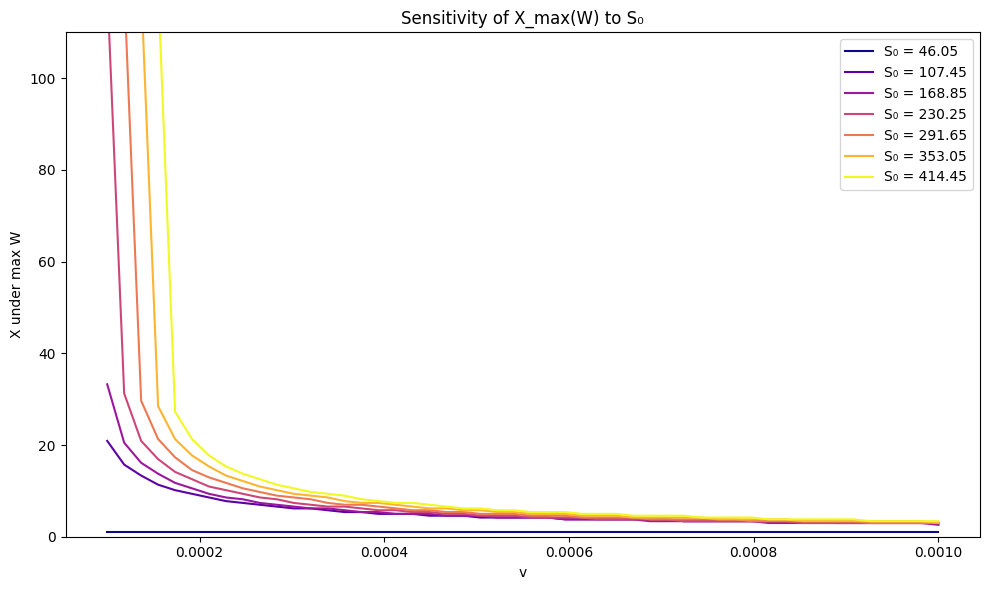

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# sensitivity for S0
μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
X_range = np.linspace(1, 120, 300)
v_values = np.linspace(0.0001, 0.001, 50)

# Create 7 levels: from -80 % to + 80%
S0_base = 230.25
S0_values = np.linspace(S0_base * 0.2, S0_base * 1.8, 7)
colors = plt.cm.plasma(np.linspace(0, 1, len(S0_values)))
labels = [f"S₀ = {S0:.2f}" for S0 in S0_values]


plt.figure(figsize=(10, 6))

for S0, color, label in zip(S0_values, colors, labels):
    alpha = (M + F) / S0
    beta = (μ * C) / S0
    X_maxima = []
    filtered_v = []

    for v in v_values:
        W_vals = []

        for X in X_range:
            p = X * μ
            try:
                n0_val = n0(p)
                I = solve_I_v(p, v)
                if np.isnan(I):
                    W_val = np.nan
                else:
                    N_val = N_from_n0_v(n0_val, p, I, v)
                    W_val = W_from_N(N_val, p, I)
            except:
                W_val = np.nan
            W_vals.append(W_val)

        if not all(np.isnan(W_vals)):
            max_idx = np.nanargmax(W_vals)
            max_X = X_range[max_idx]
            max_W = W_vals[max_idx]
            if max_W >= 0:
                filtered_v.append(v)
                X_maxima.append(max_X)

    
    plt.plot(filtered_v, X_maxima, linestyle='-', marker='', color=color, label=label)

plt.ylim(0, 110)
plt.xlabel("v")
plt.ylabel("X under max W")
plt.title("Sensitivity of X_max(W) to S₀")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig("third_model_sensitivity_Xmax(W)_to_S0.pdf", format='pdf', bbox_inches='tight')
plt.show()


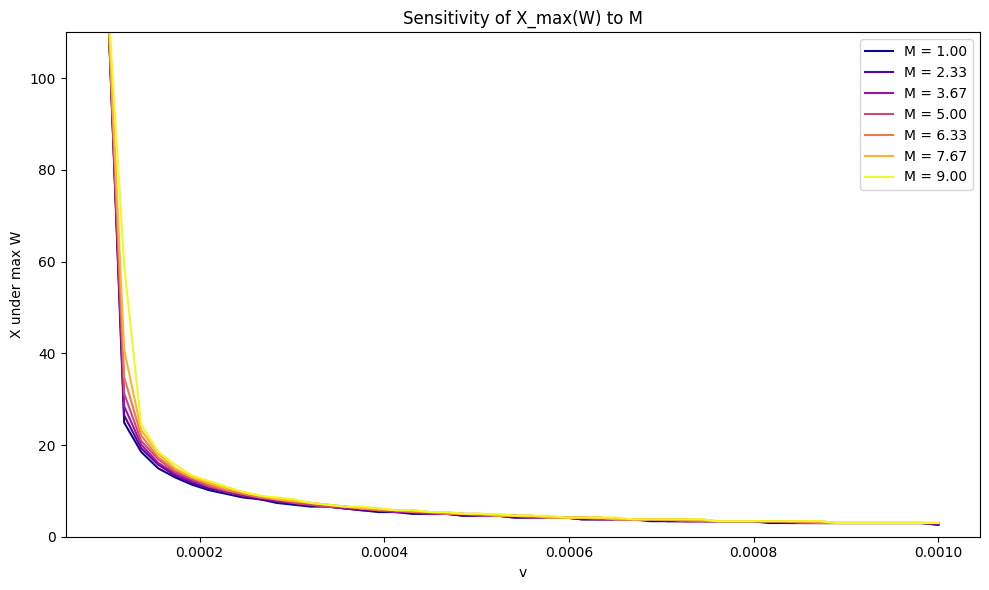

In [32]:
# Sensibility analysis for M
import numpy as np
import matplotlib.pyplot as plt

# Default parametres
μ = 0.134
m = 1e-6
F = 3
C = 137
S0 = 230.25
X_range = np.linspace(1, 120, 300)
v_values = np.linspace(0.0001, 0.001, 50)

# 7 levels M from -80% to +80%
M_base = 5
M_values = np.linspace(M_base * 0.2, M_base * 1.8, 7)
colors = plt.cm.plasma(np.linspace(0, 1, len(M_values)))
labels = [f"M = {M:.2f}" for M in M_values]


plt.figure(figsize=(10, 6))

for M, color, label in zip(M_values, colors, labels):
    alpha = (M + F) / S0
    beta = (μ * C) / S0
    X_maxima = []
    filtered_v = []

    for v in v_values:
        W_vals = []

        for X in X_range:
            p = X * μ
            try:
                n0_val = n0(p)
                I = solve_I_v(p, v)
                if np.isnan(I):
                    W_val = np.nan
                else:
                    N_val = N_from_n0_v(n0_val, p, I, v)
                    W_val = W_from_N(N_val, p, I)
            except:
                W_val = np.nan
            W_vals.append(W_val)

        if not all(np.isnan(W_vals)):
            max_idx = np.nanargmax(W_vals)
            max_X = X_range[max_idx]
            max_W = W_vals[max_idx]
            if max_W >= 0:
                filtered_v.append(v)
                X_maxima.append(max_X)

    plt.plot(filtered_v, X_maxima, linestyle='-', marker='', color=color, label=label)

plt.ylim(0, 110)
plt.xlabel("v")
plt.ylabel("X under max W")
plt.title("Sensitivity of X_max(W) to M")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig("third_model_sensitivity_Xmax(W)_to_M.pdf", format='pdf', bbox_inches='tight')
plt.show()

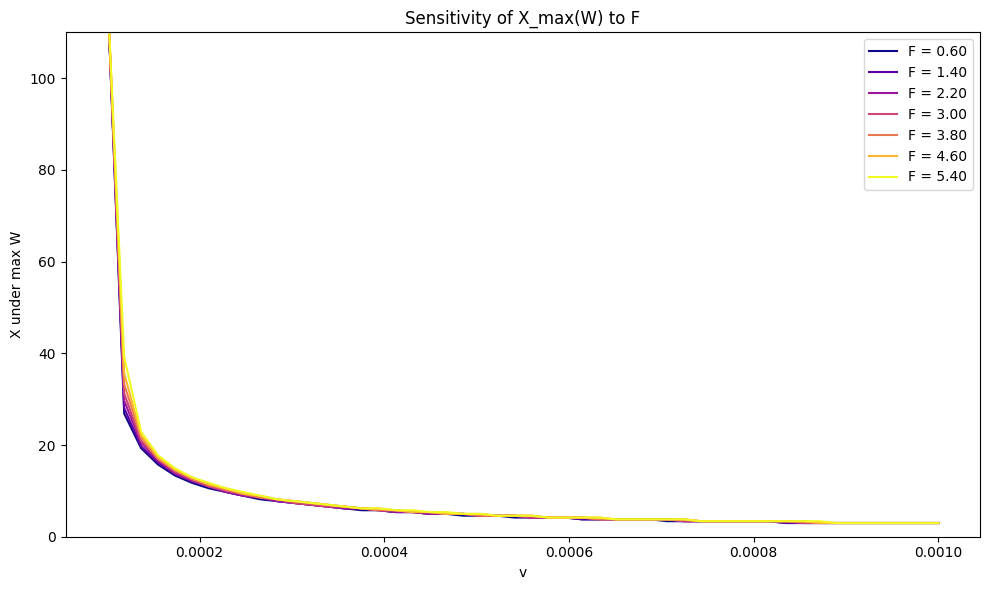

In [33]:
# Sensitivity analysis for F
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
C = 137
S0 = 230.25
X_range = np.linspace(1, 120, 300)
v_values = np.linspace(0.0001, 0.001, 50)

F_base = 3
F_values = np.linspace(F_base * 0.2, F_base * 1.8, 7)
colors = plt.cm.plasma(np.linspace(0, 1, len(F_values)))
labels = [f"F = {F:.2f}" for F in F_values]

plt.figure(figsize=(10, 6))

for F, color, label in zip(F_values, colors, labels):
    alpha = (M + F) / S0
    beta = (μ * C) / S0
    X_maxima = []
    filtered_v = []

    for v in v_values:
        W_vals = []

        for X in X_range:
            p = X * μ
            try:
                n0_val = n0(p)
                I = solve_I_v(p, v)
                if np.isnan(I):
                    W_val = np.nan
                else:
                    N_val = N_from_n0_v(n0_val, p, I, v)
                    W_val = W_from_N(N_val, p, I)
            except:
                W_val = np.nan
            W_vals.append(W_val)

        if not all(np.isnan(W_vals)):
            max_idx = np.nanargmax(W_vals)
            max_X = X_range[max_idx]
            max_W = W_vals[max_idx]
            if max_W >= 0:
                filtered_v.append(v)
                X_maxima.append(max_X)

    plt.plot(filtered_v, X_maxima, linestyle='-', marker='', color=color, label=label)

plt.ylim(0, 110)
plt.xlabel("v")
plt.ylabel("X under max W")
plt.title("Sensitivity of X_max(W) to F")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig("third_model_sensitivity_Xmax(W)_to_F.pdf", format='pdf', bbox_inches='tight')
plt.show()


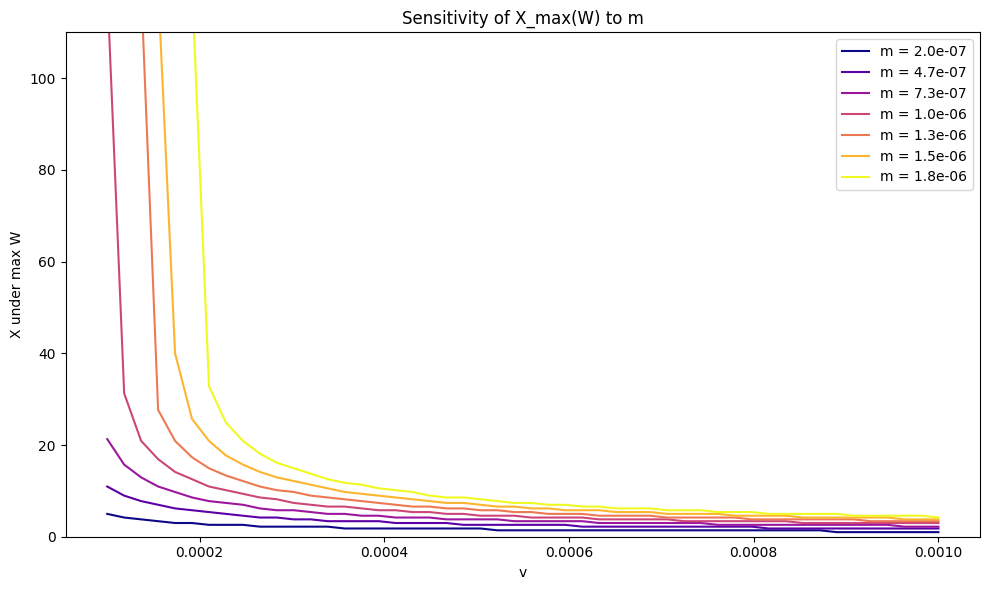

In [34]:
# Sensitivity analysis for m

import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
M = 5
F = 3
C = 137
S0 = 230.25
X_range = np.linspace(1, 120, 300)
v_values = np.linspace(0.0001, 0.001, 50)

m_base = 1e-6
m_values = np.linspace(m_base * 0.2, m_base * 1.8, 7)
colors = plt.cm.plasma(np.linspace(0, 1, len(m_values)))
labels = [f"m = {m:.1e}" for m in m_values]

plt.figure(figsize=(10, 6))

for m, color, label in zip(m_values, colors, labels):
    alpha = (M + F) / S0
    beta = (μ * C) / S0
    X_maxima = []
    filtered_v = []

    for v in v_values:
        W_vals = []

        for X in X_range:
            p = X * μ
            try:
                n0_val = n0(p)
                I = solve_I_v(p, v)
                if np.isnan(I):
                    W_val = np.nan
                else:
                    N_val = N_from_n0_v(n0_val, p, I, v)
                    W_val = W_from_N(N_val, p, I)
            except:
                W_val = np.nan
            W_vals.append(W_val)

        if not all(np.isnan(W_vals)):
            max_idx = np.nanargmax(W_vals)
            max_X = X_range[max_idx]
            max_W = W_vals[max_idx]
            if max_W >= 0:
                filtered_v.append(v)
                X_maxima.append(max_X)

    plt.plot(filtered_v, X_maxima, linestyle='-', marker='', color=color, label=label)
    
plt.ylim(0, 110)
plt.xlabel("v")
plt.ylabel("X under max W")
plt.title("Sensitivity of X_max(W) to m")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig("third_model_sensitivity_Xmax(W)_to_m.pdf", format='pdf', bbox_inches='tight')
plt.show()


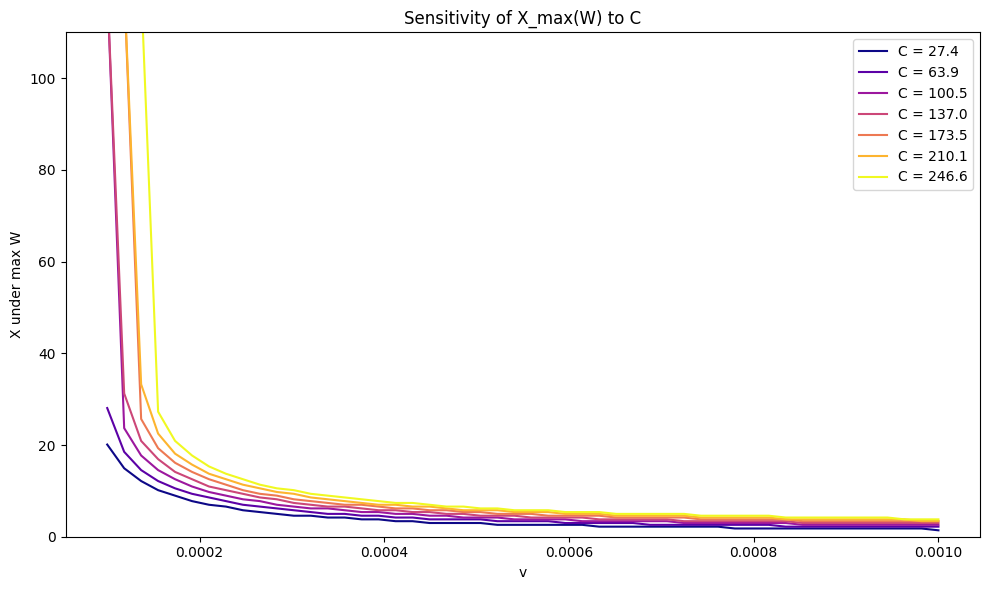

In [35]:
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
M = 5
F = 3
m = 1e-6
S0 = 230.25
X_range = np.linspace(1, 120, 300)
v_values = np.linspace(0.0001, 0.001, 50)

C_base = 137
C_values = np.linspace(C_base * 0.2, C_base * 1.8, 7)
colors = plt.cm.plasma(np.linspace(0, 1, len(C_values)))
labels = [f"C = {C:.1f}" for C in C_values]

plt.figure(figsize=(10, 6))

for C, color, label in zip(C_values, colors, labels):
    alpha = (M + F) / S0
    beta = (μ * C) / S0
    X_maxima = []
    filtered_v = []

    for v in v_values:
        W_vals = []

        for X in X_range:
            p = X * μ
            try:
                n0_val = n0(p)
                I = solve_I_v(p, v)
                if np.isnan(I):
                    W_val = np.nan
                else:
                    N_val = N_from_n0_v(n0_val, p, I, v)
                    W_val = W_from_N(N_val, p, I)
            except:
                W_val = np.nan
            W_vals.append(W_val)

        if not all(np.isnan(W_vals)):
            max_idx = np.nanargmax(W_vals)
            max_X = X_range[max_idx]
            max_W = W_vals[max_idx]
            if max_W >= 0:
                filtered_v.append(v)
                X_maxima.append(max_X)

    plt.plot(filtered_v, X_maxima, linestyle='-', marker='', color=color, label=label)
    
plt.ylim(0,110)
plt.xlabel("v")
plt.ylabel("X under max W")
plt.title("Sensitivity of X_max(W) to C")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig("third_model_sensitivity_Xmax(W)_to_C.pdf", format='pdf', bbox_inches='tight')
plt.show()


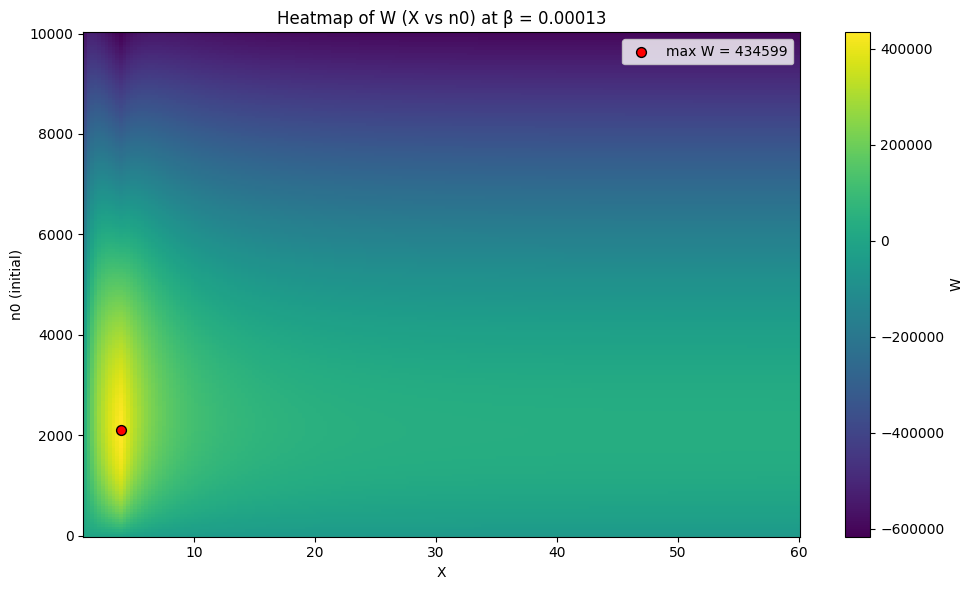

In [36]:
# Heatmap of W with X on x-axis and n0 (initial parameter) on y-axis for β = 0.00013
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta_const = (μ * C) / S0

β_target = 0.00013
v_target = β_target / μ  # convert β to v

# Grids
X_vals = np.linspace(1, 60, 200)      # X grid
n0_vals = np.linspace(1, 10000, 200)  # n0 grid (initial parameter, not computed)

# Prepare grid
W_grid = np.full((len(n0_vals), len(X_vals)), np.nan)

for ix, X in enumerate(X_vals):
    p = p_from_X(X)
    I_val = solve_I_v(p, v_target)
    if np.isnan(I_val):
        continue
    for in0, n0_val in enumerate(n0_vals):
        N_val = N_from_n0_v(n0_val, p, I_val, v_target)
        W_val = W_from_Xn0(N_val, p, I_val, n0_val)
        W_grid[in0, ix] = W_val

# Locate maximum W (ignore NaNs)
if np.all(np.isnan(W_grid)):
    max_W = np.nan
    max_X = np.nan
    max_n0 = np.nan
else:
    flat_idx = np.nanargmax(W_grid)
    in0_max, ix_max = np.unravel_index(flat_idx, W_grid.shape)
    max_W = W_grid[in0_max, ix_max]
    max_X = X_vals[ix_max]
    max_n0 = n0_vals[in0_max]

# Mask NaNs and plot
W_masked = np.ma.masked_invalid(W_grid)

plt.figure(figsize=(10, 6))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

im = plt.pcolormesh(
    X_vals,
    n0_vals,
    W_masked,
    shading='auto',
    cmap=cmap
)
plt.colorbar(im, label='W')
plt.xlabel('X')
plt.ylabel('n0 (initial)')
plt.title(f'Heatmap of W (X vs n0) at β = {β_target}')

# Mark the maximum W
if np.isfinite(max_W):
    plt.scatter(max_X, max_n0, color='red', s=50, edgecolors='black', zorder=5, label=f'max W = {max_W:.0f}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("third_model_heatmap_W_X_n0_initial_beta_0.00013.pdf", format='pdf', bbox_inches='tight')
plt.show()

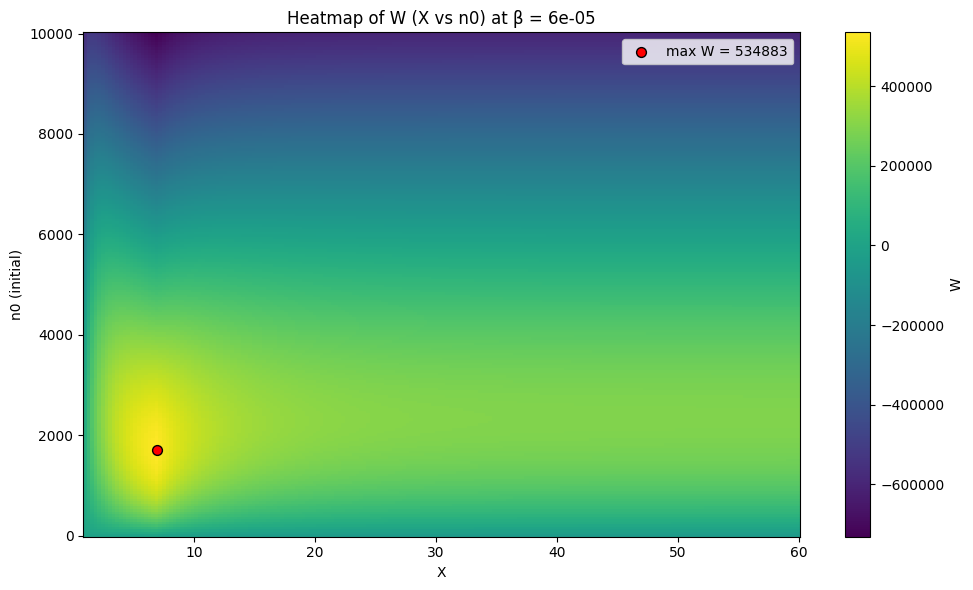

In [37]:
# Heatmap of W with X on x-axis and n0 (initial parameter) on y-axis for β = 0.00013
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta_const = (μ * C) / S0

β_target = 0.00006
v_target = β_target / μ  # convert β to v

# Grids
X_vals = np.linspace(1, 60, 200)      # X grid
n0_vals = np.linspace(1, 10000, 200)  # n0 grid (initial parameter, not computed)

# Prepare grid
W_grid = np.full((len(n0_vals), len(X_vals)), np.nan)

for ix, X in enumerate(X_vals):
    p = p_from_X(X)
    I_val = solve_I_v(p, v_target)
    if np.isnan(I_val):
        continue
    for in0, n0_val in enumerate(n0_vals):
        N_val = N_from_n0_v(n0_val, p, I_val, v_target)
        W_val = W_from_Xn0(N_val, p, I_val, n0_val)
        W_grid[in0, ix] = W_val

# Locate maximum W (ignore NaNs)
if np.all(np.isnan(W_grid)):
    max_W = np.nan
    max_X = np.nan
    max_n0 = np.nan
else:
    flat_idx = np.nanargmax(W_grid)
    in0_max, ix_max = np.unravel_index(flat_idx, W_grid.shape)
    max_W = W_grid[in0_max, ix_max]
    max_X = X_vals[ix_max]
    max_n0 = n0_vals[in0_max]

# Mask NaNs and plot
W_masked = np.ma.masked_invalid(W_grid)

plt.figure(figsize=(10, 6))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

im = plt.pcolormesh(
    X_vals,
    n0_vals,
    W_masked,
    shading='auto',
    cmap=cmap
)
plt.colorbar(im, label='W')
plt.xlabel('X')
plt.ylabel('n0 (initial)')
plt.title(f'Heatmap of W (X vs n0) at β = {β_target}')

# Mark the maximum W
if np.isfinite(max_W):
    plt.scatter(max_X, max_n0, color='red', s=50, edgecolors='black', zorder=5, label=f'max W = {max_W:.0f}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("third_model_heatmap_W_X_n0_initial_beta_0.00006.pdf", format='pdf', bbox_inches='tight')
plt.show()

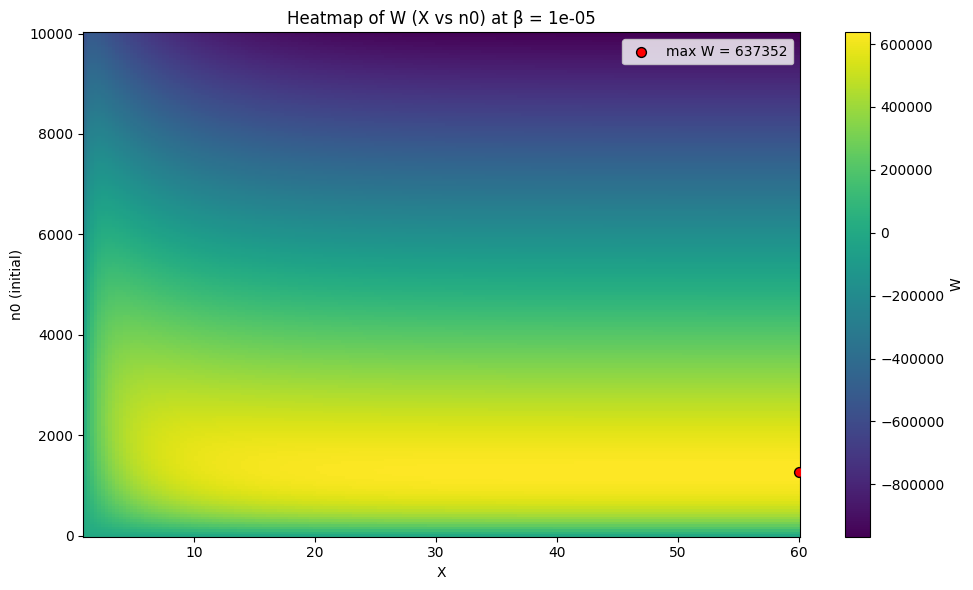

In [38]:
# Heatmap of W with X on x-axis and n0 (initial parameter) on y-axis for β = 0.00013
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta_const = (μ * C) / S0

β_target = 0.00001
v_target = β_target / μ  # convert β to v

# Grids
X_vals = np.linspace(1, 60, 200)      # X grid
n0_vals = np.linspace(1, 10000, 200)  # n0 grid (initial parameter, not computed)

# Prepare grid
W_grid = np.full((len(n0_vals), len(X_vals)), np.nan)

for ix, X in enumerate(X_vals):
    p = p_from_X(X)
    I_val = solve_I_v(p, v_target)
    if np.isnan(I_val):
        continue
    for in0, n0_val in enumerate(n0_vals):
        N_val = N_from_n0_v(n0_val, p, I_val, v_target)
        W_val = W_from_Xn0(N_val, p, I_val, n0_val)
        W_grid[in0, ix] = W_val

# Locate maximum W (ignore NaNs)
if np.all(np.isnan(W_grid)):
    max_W = np.nan
    max_X = np.nan
    max_n0 = np.nan
else:
    flat_idx = np.nanargmax(W_grid)
    in0_max, ix_max = np.unravel_index(flat_idx, W_grid.shape)
    max_W = W_grid[in0_max, ix_max]
    max_X = X_vals[ix_max]
    max_n0 = n0_vals[in0_max]

# Mask NaNs and plot
W_masked = np.ma.masked_invalid(W_grid)

plt.figure(figsize=(10, 6))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

im = plt.pcolormesh(
    X_vals,
    n0_vals,
    W_masked,
    shading='auto',
    cmap=cmap
)
plt.colorbar(im, label='W')
plt.xlabel('X')
plt.ylabel('n0 (initial)')
plt.title(f'Heatmap of W (X vs n0) at β = {β_target}')

# Mark the maximum W
if np.isfinite(max_W):
    plt.scatter(max_X, max_n0, color='red', s=50, edgecolors='black', zorder=5, label=f'max W = {max_W:.0f}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("third_model_heatmap_W_X_n0_initial_beta_0.00001.pdf", format='pdf', bbox_inches='tight')
plt.show()

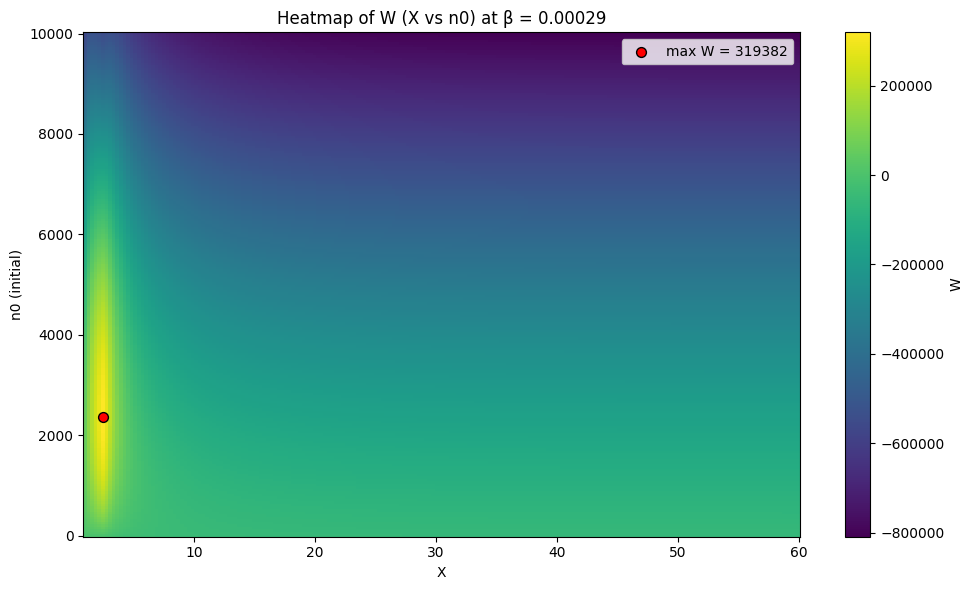

In [39]:
# Heatmap of W with X on x-axis and n0 (initial parameter) on y-axis for β = 0.00013
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta_const = (μ * C) / S0

β_target = 0.00029
v_target = β_target / μ  # convert β to v

# Grids
X_vals = np.linspace(1, 60, 200)      # X grid
n0_vals = np.linspace(1, 10000, 200)  # n0 grid (initial parameter, not computed)

# Prepare grid
W_grid = np.full((len(n0_vals), len(X_vals)), np.nan)

for ix, X in enumerate(X_vals):
    p = p_from_X(X)
    I_val = solve_I_v(p, v_target)
    if np.isnan(I_val):
        continue
    for in0, n0_val in enumerate(n0_vals):
        N_val = N_from_n0_v(n0_val, p, I_val, v_target)
        W_val = W_from_Xn0(N_val, p, I_val, n0_val)
        W_grid[in0, ix] = W_val

# Locate maximum W (ignore NaNs)
if np.all(np.isnan(W_grid)):
    max_W = np.nan
    max_X = np.nan
    max_n0 = np.nan
else:
    flat_idx = np.nanargmax(W_grid)
    in0_max, ix_max = np.unravel_index(flat_idx, W_grid.shape)
    max_W = W_grid[in0_max, ix_max]
    max_X = X_vals[ix_max]
    max_n0 = n0_vals[in0_max]

# Mask NaNs and plot
W_masked = np.ma.masked_invalid(W_grid)

plt.figure(figsize=(10, 6))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

im = plt.pcolormesh(
    X_vals,
    n0_vals,
    W_masked,
    shading='auto',
    cmap=cmap
)
plt.colorbar(im, label='W')
plt.xlabel('X')
plt.ylabel('n0 (initial)')
plt.title(f'Heatmap of W (X vs n0) at β = {β_target}')

# Mark the maximum W
if np.isfinite(max_W):
    plt.scatter(max_X, max_n0, color='red', s=50, edgecolors='black', zorder=5, label=f'max W = {max_W:.0f}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("third_model_heatmap_W_X_n0_initial_beta_0.00029.pdf", format='pdf', bbox_inches='tight')
plt.show()

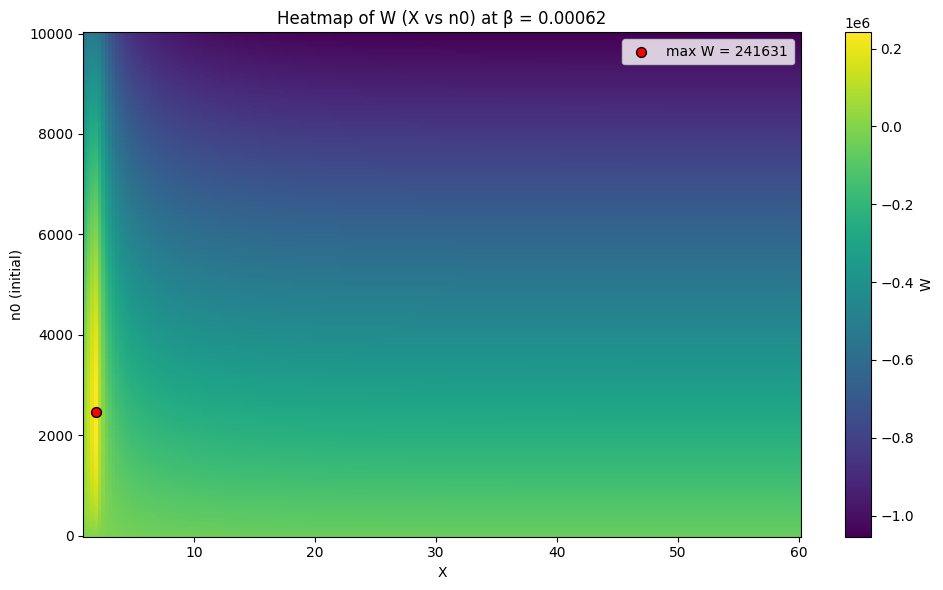

In [40]:
# Heatmap of W with X on x-axis and n0 (initial parameter) on y-axis for β = 0.00013
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta_const = (μ * C) / S0

β_target = 0.00062
v_target = β_target / μ  # convert β to v

# Grids
X_vals = np.linspace(1, 60, 200)      # X grid
n0_vals = np.linspace(1, 10000, 200)  # n0 grid (initial parameter, not computed)

# Prepare grid
W_grid = np.full((len(n0_vals), len(X_vals)), np.nan)

for ix, X in enumerate(X_vals):
    p = p_from_X(X)
    I_val = solve_I_v(p, v_target)
    if np.isnan(I_val):
        continue
    for in0, n0_val in enumerate(n0_vals):
        N_val = N_from_n0_v(n0_val, p, I_val, v_target)
        W_val = W_from_Xn0(N_val, p, I_val, n0_val)
        W_grid[in0, ix] = W_val

# Locate maximum W (ignore NaNs)
if np.all(np.isnan(W_grid)):
    max_W = np.nan
    max_X = np.nan
    max_n0 = np.nan
else:
    flat_idx = np.nanargmax(W_grid)
    in0_max, ix_max = np.unravel_index(flat_idx, W_grid.shape)
    max_W = W_grid[in0_max, ix_max]
    max_X = X_vals[ix_max]
    max_n0 = n0_vals[in0_max]

# Mask NaNs and plot
W_masked = np.ma.masked_invalid(W_grid)

plt.figure(figsize=(10, 6))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

im = plt.pcolormesh(
    X_vals,
    n0_vals,
    W_masked,
    shading='auto',
    cmap=cmap
)
plt.colorbar(im, label='W')
plt.xlabel('X')
plt.ylabel('n0 (initial)')
plt.title(f'Heatmap of W (X vs n0) at β = {β_target}')

# Mark the maximum W
if np.isfinite(max_W):
    plt.scatter(max_X, max_n0, color='red', s=50, edgecolors='black', zorder=5, label=f'max W = {max_W:.0f}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("third_model_heatmap_W_X_n0_initial_beta_0.00062.pdf", format='pdf', bbox_inches='tight')
plt.show()

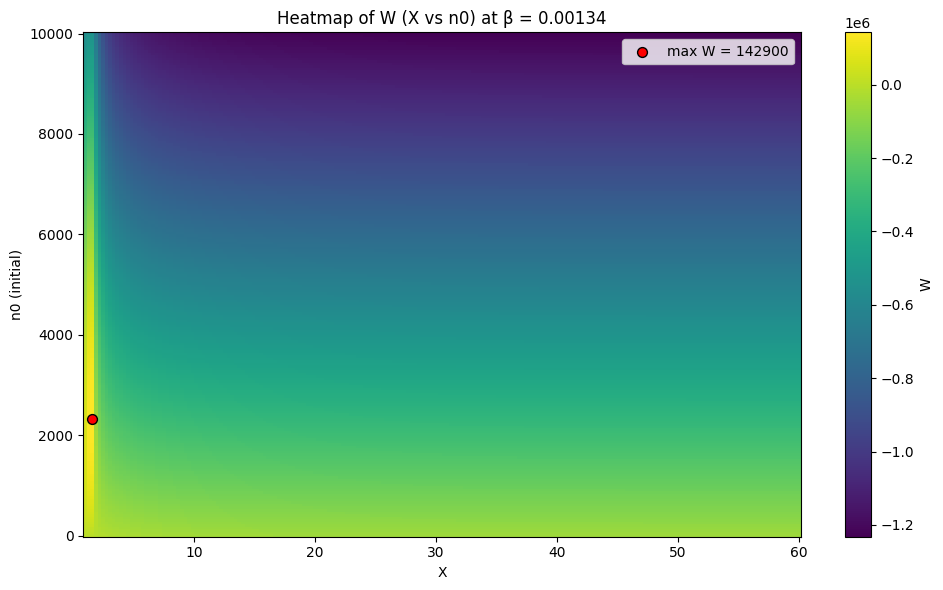

In [41]:
# Heatmap of W with X on x-axis and n0 (initial parameter) on y-axis for β = 0.00013
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta_const = (μ * C) / S0

β_target = 0.00134
v_target = β_target / μ  # convert β to v

# Grids
X_vals = np.linspace(1, 60, 200)      # X grid
n0_vals = np.linspace(1, 10000, 200)  # n0 grid (initial parameter, not computed)

# Prepare grid
W_grid = np.full((len(n0_vals), len(X_vals)), np.nan)

for ix, X in enumerate(X_vals):
    p = p_from_X(X)
    I_val = solve_I_v(p, v_target)
    if np.isnan(I_val):
        continue
    for in0, n0_val in enumerate(n0_vals):
        N_val = N_from_n0_v(n0_val, p, I_val, v_target)
        W_val = W_from_Xn0(N_val, p, I_val, n0_val)
        W_grid[in0, ix] = W_val

# Locate maximum W (ignore NaNs)
if np.all(np.isnan(W_grid)):
    max_W = np.nan
    max_X = np.nan
    max_n0 = np.nan
else:
    flat_idx = np.nanargmax(W_grid)
    in0_max, ix_max = np.unravel_index(flat_idx, W_grid.shape)
    max_W = W_grid[in0_max, ix_max]
    max_X = X_vals[ix_max]
    max_n0 = n0_vals[in0_max]

# Mask NaNs and plot
W_masked = np.ma.masked_invalid(W_grid)

plt.figure(figsize=(10, 6))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

im = plt.pcolormesh(
    X_vals,
    n0_vals,
    W_masked,
    shading='auto',
    cmap=cmap
)
plt.colorbar(im, label='W')
plt.xlabel('X')
plt.ylabel('n0 (initial)')
plt.title(f'Heatmap of W (X vs n0) at β = {β_target}')

# Mark the maximum W
if np.isfinite(max_W):
    plt.scatter(max_X, max_n0, color='red', s=50, edgecolors='black', zorder=5, label=f'max W = {max_W:.0f}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("third_model_heatmap_W_X_n0_initial_beta_0.00134.pdf", format='pdf', bbox_inches='tight')
plt.show()

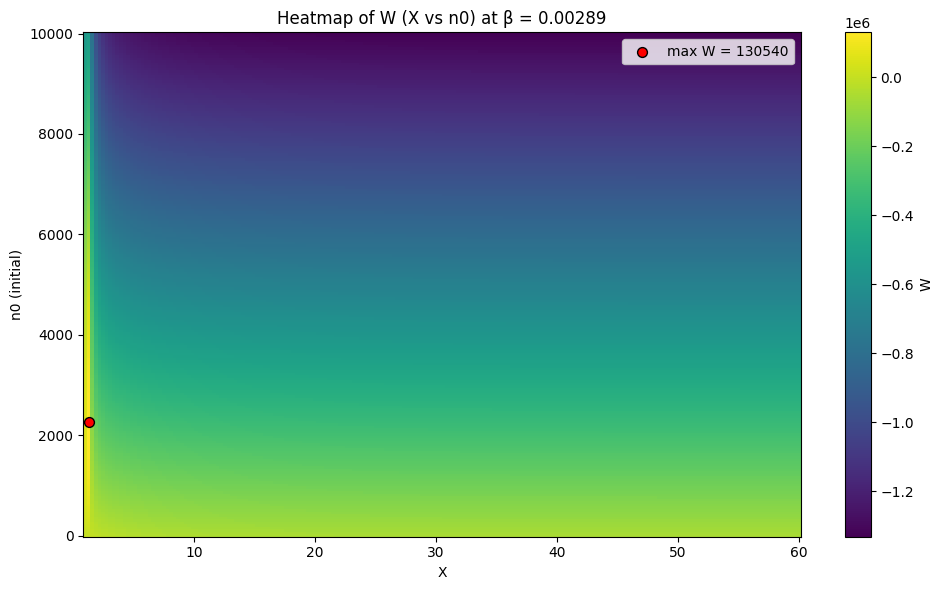

In [42]:
# Heatmap of W with X on x-axis and n0 (initial parameter) on y-axis for β = 0.00013
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta_const = (μ * C) / S0

β_target = 0.00289
v_target = β_target / μ  # convert β to v

# Grids
X_vals = np.linspace(1, 60, 200)      # X grid
n0_vals = np.linspace(1, 10000, 200)  # n0 grid (initial parameter, not computed)

# Prepare grid
W_grid = np.full((len(n0_vals), len(X_vals)), np.nan)

for ix, X in enumerate(X_vals):
    p = p_from_X(X)
    I_val = solve_I_v(p, v_target)
    if np.isnan(I_val):
        continue
    for in0, n0_val in enumerate(n0_vals):
        N_val = N_from_n0_v(n0_val, p, I_val, v_target)
        W_val = W_from_Xn0(N_val, p, I_val, n0_val)
        W_grid[in0, ix] = W_val

# Locate maximum W (ignore NaNs)
if np.all(np.isnan(W_grid)):
    max_W = np.nan
    max_X = np.nan
    max_n0 = np.nan
else:
    flat_idx = np.nanargmax(W_grid)
    in0_max, ix_max = np.unravel_index(flat_idx, W_grid.shape)
    max_W = W_grid[in0_max, ix_max]
    max_X = X_vals[ix_max]
    max_n0 = n0_vals[in0_max]

# Mask NaNs and plot
W_masked = np.ma.masked_invalid(W_grid)

plt.figure(figsize=(10, 6))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

im = plt.pcolormesh(
    X_vals,
    n0_vals,
    W_masked,
    shading='auto',
    cmap=cmap
)
plt.colorbar(im, label='W')
plt.xlabel('X')
plt.ylabel('n0 (initial)')
plt.title(f'Heatmap of W (X vs n0) at β = {β_target}')

# Mark the maximum W
if np.isfinite(max_W):
    plt.scatter(max_X, max_n0, color='red', s=50, edgecolors='black', zorder=5, label=f'max W = {max_W:.0f}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("third_model_heatmap_W_X_n0_initial_beta_0.00289.pdf", format='pdf', bbox_inches='tight')
plt.show()

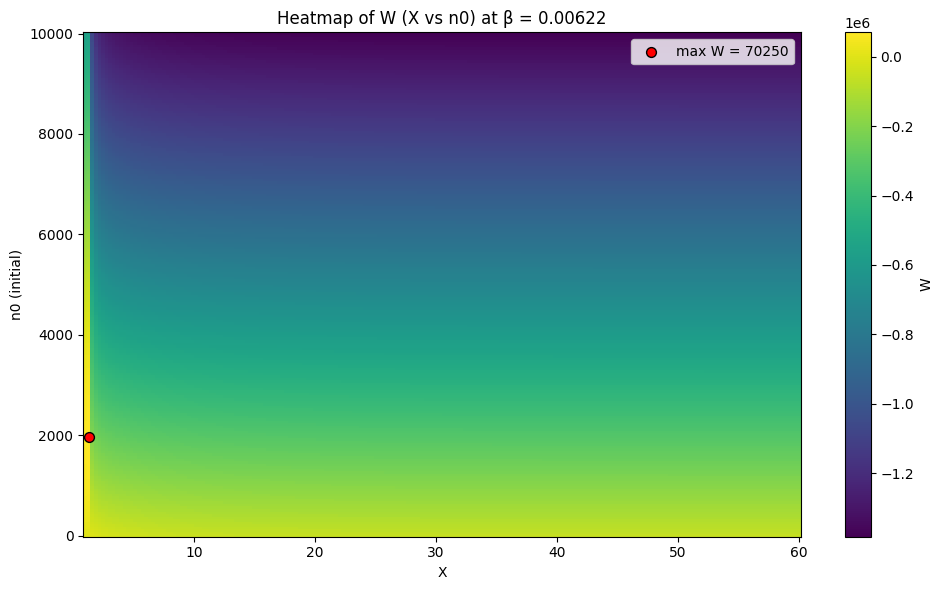

In [43]:
# Heatmap of W with X on x-axis and n0 (initial parameter) on y-axis for β = 0.00013
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta_const = (μ * C) / S0

β_target = 0.00622
v_target = β_target / μ  # convert β to v

# Grids
X_vals = np.linspace(1, 60, 200)      # X grid
n0_vals = np.linspace(1, 10000, 200)  # n0 grid (initial parameter, not computed)

# Prepare grid
W_grid = np.full((len(n0_vals), len(X_vals)), np.nan)

for ix, X in enumerate(X_vals):
    p = p_from_X(X)
    I_val = solve_I_v(p, v_target)
    if np.isnan(I_val):
        continue
    for in0, n0_val in enumerate(n0_vals):
        N_val = N_from_n0_v(n0_val, p, I_val, v_target)
        W_val = W_from_Xn0(N_val, p, I_val, n0_val)
        W_grid[in0, ix] = W_val

# Locate maximum W (ignore NaNs)
if np.all(np.isnan(W_grid)):
    max_W = np.nan
    max_X = np.nan
    max_n0 = np.nan
else:
    flat_idx = np.nanargmax(W_grid)
    in0_max, ix_max = np.unravel_index(flat_idx, W_grid.shape)
    max_W = W_grid[in0_max, ix_max]
    max_X = X_vals[ix_max]
    max_n0 = n0_vals[in0_max]

# Mask NaNs and plot
W_masked = np.ma.masked_invalid(W_grid)

plt.figure(figsize=(10, 6))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

im = plt.pcolormesh(
    X_vals,
    n0_vals,
    W_masked,
    shading='auto',
    cmap=cmap
)
plt.colorbar(im, label='W')
plt.xlabel('X')
plt.ylabel('n0 (initial)')
plt.title(f'Heatmap of W (X vs n0) at β = {β_target}')

# Mark the maximum W
if np.isfinite(max_W):
    plt.scatter(max_X, max_n0, color='red', s=50, edgecolors='black', zorder=5, label=f'max W = {max_W:.0f}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("third_model_heatmap_W_X_n0_initial_beta_0.00622.pdf", format='pdf', bbox_inches='tight')
plt.show()

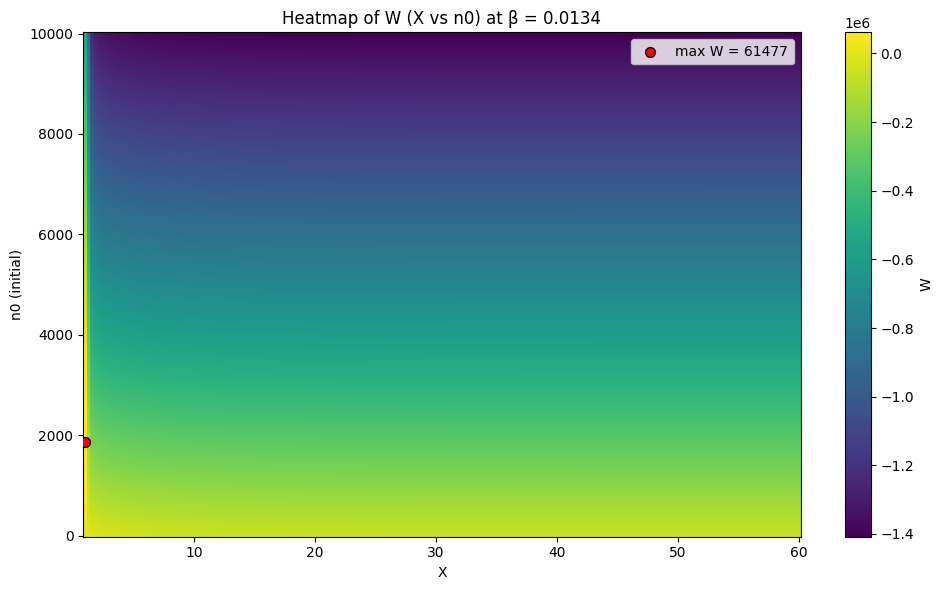

In [44]:
# Heatmap of W with X on x-axis and n0 (initial parameter) on y-axis for β = 0.00013
import numpy as np
import matplotlib.pyplot as plt

μ = 0.134
m = 1e-6
M = 5
F = 3
C = 137
S0 = 230.25

alpha = (M + F) / S0
beta_const = (μ * C) / S0

β_target = 0.01340
v_target = β_target / μ  # convert β to v

# Grids
X_vals = np.linspace(1, 60, 200)      # X grid
n0_vals = np.linspace(1, 10000, 200)  # n0 grid (initial parameter, not computed)

# Prepare grid
W_grid = np.full((len(n0_vals), len(X_vals)), np.nan)

for ix, X in enumerate(X_vals):
    p = p_from_X(X)
    I_val = solve_I_v(p, v_target)
    if np.isnan(I_val):
        continue
    for in0, n0_val in enumerate(n0_vals):
        N_val = N_from_n0_v(n0_val, p, I_val, v_target)
        W_val = W_from_Xn0(N_val, p, I_val, n0_val)
        W_grid[in0, ix] = W_val

# Locate maximum W (ignore NaNs)
if np.all(np.isnan(W_grid)):
    max_W = np.nan
    max_X = np.nan
    max_n0 = np.nan
else:
    flat_idx = np.nanargmax(W_grid)
    in0_max, ix_max = np.unravel_index(flat_idx, W_grid.shape)
    max_W = W_grid[in0_max, ix_max]
    max_X = X_vals[ix_max]
    max_n0 = n0_vals[in0_max]

# Mask NaNs and plot
W_masked = np.ma.masked_invalid(W_grid)

plt.figure(figsize=(10, 6))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

im = plt.pcolormesh(
    X_vals,
    n0_vals,
    W_masked,
    shading='auto',
    cmap=cmap
)
plt.colorbar(im, label='W')
plt.xlabel('X')
plt.ylabel('n0 (initial)')
plt.title(f'Heatmap of W (X vs n0) at β = {β_target}')

# Mark the maximum W
if np.isfinite(max_W):
    plt.scatter(max_X, max_n0, color='red', s=50, edgecolors='black', zorder=5, label=f'max W = {max_W:.0f}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("third_model_heatmap_W_X_n0_initial_beta_0.01340.pdf", format='pdf', bbox_inches='tight')
plt.show()